# Full Name: Arnav Boppudi
# • Userid: ab2kk@virginia.edu
# • GitHub Repo URL: https://github.com/arnavboppudi/ETA_LOTR
# • UVA Box URL: https://app.box.com/s/0yfc7j2qae0btu3mhiwtv5ek6v0sy6pi

In [6]:
#pip install plotly_express

In [7]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px

import configparser

import sys

#from textparser import TextParser

In [8]:
# import configparser
# config = configparser.ConfigParser()
# config.read("env.ini")
# data_home = config['DEFAULT']['data_home']
# output_dir = config['DEFAULT']['output_dir']

In [9]:
#text_file = f"LOTR.txt"

In [10]:
#source_files = f'{data_home}LOTR'

In [11]:
#source_files = f'{data_home}/LOTR'

In [12]:
#glob(f"{source_files}/*.*")

In [13]:
text_file_1 = "book_1.txt"
text_file_2 = "book_2.txt"
text_file_3 = "book_3.txt"
text_file_4 = "book_4.txt"
text_file_5 = "book_5.txt"
text_file_6 = "book_6.txt"

In [14]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [15]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_1, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

In [16]:
LINES.sample(20)

line_str
line_num                                                   
445       At first Frodo was a good deal disturbed, and ...
366       A heavy silence fell in the room. Frodo could ...
1049                                                       
1733      'I do not know,' Strider answered. 'It is too ...
658       'Courage is found in unlikely places,' said Gi...
904                                                        
842                    in a fountain white beneath the sky;
1489      'There's some mistake somewhere,' said Butterb...
2044                                    Warn him! Darn him!
825                                                        
612       'I am Gildor,' answered their leader, the Elf ...
1668                                                       
529       'Then you know or guess something about this r...
1233                      till the dark lord lifts his hand
1495      He came forward into the firelight; but most o...
1472                             they all went back to bed!
1663      The night deepened. There came the soft sound ...
384       Frodo drew the Ring out of his pocket again an...
288                                                        
456       'Our last meal at Bag End!' said Frodo, pushin...

In [17]:
chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

Lines matching chapter pattern: 12


In [18]:
if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

line_str  chap_num
line_num                                                             
1102      Bright blue his jacket is, and his boots are y...         7
1476      The local hobbits stared in amazement, and the...         9
2003                          For meat was hard to come by.        12
476       After a while they plunged into a deeply clove...         3
1482      'A matter of some importance  to us both,' an...         9
164       The Sackville-Bagginses were rather offensive....         1
369       'Yes, alas! through him the Enemy has learned ...         2
298          In the Land of Mordor where the Shadows lie.'_         2
1285      White-socks my little lad, and old Fatty Lumpkin!         8
280         'Hold it up!' said Gandalf. 'And look closely!'         2

In [19]:
print(LINES)

                                                   line_str  chap_num
line_num                                                             
0                                               CHAPTER ONE         1
1                                     A Long-expected Party         1
2                                                                   1
3         When Mr. Bilbo Baggins of Bag End announced th...         1
4         Bilbo was very rich and very peculiar, and had...         1
...                                                     ...       ...
2116      'By Elbereth and Lúthien the Fair,' said Frodo...        12
2117      Then the leader, who was now half across the F...        12
2118      At that moment there came a roaring and a rush...        12
2119      With his last failing senses Frodo heard cries...        12
2120      The black horses were filled with madness, and...        12

[2121 rows x 2 columns]


In [20]:
# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)

# Since we don't have book_id, sent_num, and token_num at this point, you would need to incorporate those in subsequent processing steps.
# Display the first few paragraphs
PARAS.head()

chap_num  para_num                                           para_str
0         1         0                 CHAPTER ONE\nA Long-expected Party
1         1         1  When Mr. Bilbo Baggins of Bag End announced th...
2         1         2  Twelve more years passed. Each year the Baggin...
3         1         3  That very month was September, and as fine as ...
4         1         4  That was Gandalf's mark, of course, and the ol...

In [21]:
# Set up the OHCO index hierarchy
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

# Your dataframe 'LINES' should already be properly loaded and chapters identified

# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 1) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_1_DF = TOKENS
BOOK_1_DF.head(40)

token_str      term_str
book_id chap_num para_num sent_num token_num                            
1       1        0        0        0               CHAPTER       chapter
                                   1                   ONE           one
                                   2                     A             a
                                   3                  Long          long
                                   4              expected      expected
                                   5                 Party         party
                 1        0        0                  When          when
                                   1                   Mr.            mr
                          1        0                 Bilbo         bilbo
                                   1               Baggins       baggins
                                   2                    of            of
                                   3                   Bag           bag
                                   4                   End           end
                                   5             announced     announced
                                   6                  that          that
                                   7                    he            he
                                   8                 would         would
                                   9               shortly       shortly
                                   10                   be            be
                                   11          celebrating   celebrating
                                   12                  his           his
                                   13             eleventy      eleventy
                                   14                first         first
                                   15             birthday      birthday
                                   16                 with          with
                                   17                    a             a
                                   18                party         party
                                   19                   of            of
                                   20              special       special
                                   21         magnificence  magnificence
                                   22                there         there
                                   23                  was           was
                                   24                 much          much
                                   25                 talk          talk
                                   26                  and           and
                                   27           excitement    excitement
                                   28                   in            in
                                   29            Hobbiton.      hobbiton
                          2        0                 Bilbo         bilbo
                                   1                   was           was

In [22]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_2, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 2) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_2_DF = TOKENS
BOOK_2_DF.head(40)

Lines matching chapter pattern: 10


token_str    term_str
book_id chap_num para_num sent_num token_num                        
2       1        0        0        0             CHAPTER     chapter
                                   1                 ONE         one
                                   2                Many        many
                                   3            Meetings    meetings
                 1        0        0               Frodo       frodo
                                   1                woke        woke
                                   2                 and         and
                                   3               found       found
                                   4             himself     himself
                                   5               lying       lying
                                   6                  in          in
                                   7                bed.         bed
                          1        0                  At          at
                                   1               first       first
                                   2                  he          he
                                   3             thought     thought
                                   4                that        that
                                   5                  he          he
                                   6                 had         had
                                   7               slept       slept
                                   8                late        late
                                   9               after       after
                                   10                  a           a
                                   11               long        long
                                   12         unpleasant  unpleasant
                                   13              dream       dream
                                   14               that        that
                                   15              still       still
                                   16            hovered     hovered
                                   17                 on          on
                                   18                the         the
                                   19               edge        edge
                                   20                 of          of
                                   21            memory.      memory
                          2        0                  Or          or
                                   1             perhaps     perhaps
                                   2                  he          he
                                   3                 had         had
                                   4                been        been
                                   5                ill?         ill

In [23]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_3, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 3) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_3_DF = TOKENS
BOOK_3_DF.head(40)

Lines matching chapter pattern: 11


token_str    term_str
book_id chap_num para_num sent_num token_num                        
3       1        0        0        0             CHAPTER     chapter
                                   1                 ONE         one
                                   2                 The         the
                                   3           Departure   departure
                                   4                  of          of
                                   5             Boromir     boromir
                 1        0        0             Aragorn     aragorn
                                   1                sped        sped
                                   2                  on          on
                                   3                  up          up
                                   4                 the         the
                                   5               hill.        hill
                          1        0               Every       every
                                   1                 now         now
                                   2                 and         and
                                   3               again       again
                                   4                  he          he
                                   5                bent        bent
                                   6                  to          to
                                   7                 the         the
                                   8             ground.      ground
                          2        0             Hobbits     hobbits
                                   1                  go          go
                                   2               light       light
                                   3                 and         and
                                   4               their       their
                                   5          footprints  footprints
                                   6                 are         are
                                   7                 not         not
                                   8                easy        easy
                                   9                even        even
                                   10                for         for
                                   11                  a           a
                                   12             Ranger      ranger
                                   13                 to          to
                                   14               read        read
                                   15                but         but
                                   16                not         not
                                   17                far         far
                                   18               from        from

In [24]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_4, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 4) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_4_DF = TOKENS
BOOK_4_DF.head(40)

Lines matching chapter pattern: 10


token_str      term_str
book_id chap_num para_num sent_num token_num                            
4       1        0        0        0               CHAPTER       chapter
                                   1                   ONE           one
                                   2                   The           the
                                   3                Taming        taming
                                   4                    of            of
                                   5              SmÃagol       smãagol
                 1        0        0                                    
                                   1                  Well          well
                                   2                master        master
                                   3                    we            we
                                   4                    re            re
                                   5                    in            in
                                   6                     a             a
                                   7                   fix           fix
                                   8                   and           and
                                   9                    no            no
                                   10              mistake       mistake
                                   11                 said          said
                                   12                  Sam           sam
                                   13              Gamgee.        gamgee
                          1        0                    He            he
                                   1                 stood         stood
                                   2          despondently  despondently
                                   3                  with          with
                                   4               hunched       hunched
                                   5             shoulders     shoulders
                                   6                beside        beside
                                   7                 Frodo         frodo
                                   8                   and           and
                                   9                peered        peered
                                   10                  out           out
                                   11                 with          with
                                   12             puckered      puckered
                                   13                 eyes          eyes
                                   14                 into          into
                                   15                  the           the
                                   16               gloom.         gloom
                          2        0                    It            it
                                   1                   was           was
                                   2                   the           the

In [25]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_5, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 5) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_5_DF = TOKENS
BOOK_5_DF.head(40)

Lines matching chapter pattern: 10


token_str  term_str
book_id chap_num para_num sent_num token_num                    
5       1        0        0        0           CHAPTER   chapter
                                   1               ONE       one
                                   2             Minas     minas
                                   3            Tirith    tirith
                 1        0        0            Pippin    pippin
                                   1            looked    looked
                                   2               out       out
                                   3              from      from
                                   4               the       the
                                   5           shelter   shelter
                                   6                of        of
                                   7           Gandalf   gandalf
                                   8                 s         s
                                   9            cloak.     cloak
                          1        0                He        he
                                   1          wondered  wondered
                                   2                if        if
                                   3                he        he
                                   4               was       was
                                   5             awake     awake
                                   6                or        or
                                   7             still     still
                                   8          sleeping  sleeping
                                   9             still     still
                                   10               in        in
                                   11              the       the
                                   12            swift     swift
                                   13           moving    moving
                                   14            dream     dream
                                   15               in        in
                                   16            which     which
                                   17               he        he
                                   18              had       had
                                   19             been      been
                                   20          wrapped   wrapped
                                   21               so        so
                                   22             long      long
                                   23            since     since
                                   24              the       the
                                   25            great     great

In [26]:
# Try with 'ISO-8859-1' encoding
LINES = pd.DataFrame(open(text_file_6, 'r', encoding='ISO-8859-1').readlines(), columns=['line_str'])
LINES.index.name = 'line_num'
LINES.line_str = LINES.line_str.str.replace(r'\n+', ' ', regex=True).str.strip()

chap_pat = r"^\s*CHAPTER\s+(\d+|[A-Z]+)"
chap_lines = LINES.line_str.str.match(chap_pat, case=False)  # Returns a truth vector

# Check if any lines are matching (for debugging)
print("Lines matching chapter pattern:", chap_lines.sum())

if chap_lines.sum() > 0:
    LINES['chap_num'] = None
    LINES.loc[chap_lines, 'chap_num'] = range(1, chap_lines.sum() + 1)
    # Step 3: Forward fill chapter numbers
    LINES['chap_num'] = LINES['chap_num'].ffill()
else:
    print("No chapter lines detected, check the regex pattern and text content.")

# Check results
LINES[['line_str', 'chap_num']].sample(10)

# Use chap_num for grouping since that's the level of interest currently
CHAPS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')

# Split the chapter text into paragraphs based on two or more newline characters
PARAS = CHAPS['chap_str'].str.split(r'\n\n+', expand=True).stack()\
    .to_frame('para_str')

# The result will have a double index: the first level is chap_num and the second is an auto-generated number by stack(), which we can consider as para_num
PARAS.index.names = ['chap_num', 'para_num']

# Reset the index to add para_num as a column
PARAS.reset_index(inplace=True)


# SPLIT INTO PARAGRAPHS
PARAS = LINES.groupby('chap_num').line_str.apply(lambda x: '\n'.join(x)).to_frame('chap_str')
PARAS = PARAS['chap_str'].str.split(r'\n\n+', expand=True).stack().to_frame('para_str')
PARAS.index.names = OHCO[1:3] # We use only 'chap_num' and 'para_num' for now
PARAS['para_str'] = PARAS['para_str'].str.replace(r'\n', ' ', regex=True).str.strip()
PARAS = PARAS[~PARAS['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

# SPLIT INTO SENTENCES
# The regex is adjusted to include sentence terminators and potential quotation marks
SENTS = PARAS['para_str'].str.split(r'(?<=[.!?"]) +', expand=True).stack().to_frame('sent_str')
SENTS.index.names = OHCO[1:4] # 'chap_num', 'para_num', and 'sent_num'

# SPLIT INTO TOKENS
TOKENS = SENTS['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame('token_str')
TOKENS.index.names = OHCO[1:5] # 'chap_num', 'para_num', 'sent_num', and 'token_num'
TOKENS['term_str'] = TOKENS['token_str'].str.replace(r"[\W_]+", '', regex=True).str.lower()

# Reset the index to line up with the OHCO pattern
# This will add 'book_id' as a placeholder for now, which you can fill with actual book IDs if you have multiple books
TOKENS.reset_index(inplace=True)
TOKENS.insert(0, 'book_id', 6) # Assuming 0 as a placeholder for 'book_id'
TOKENS.set_index(OHCO, inplace=True)

# Display the first few tokens to confirm structure
BOOK_6_DF = TOKENS
BOOK_6_DF.head(40)

Lines matching chapter pattern: 9


token_str   term_str
book_id chap_num para_num sent_num token_num                      
6       1        0        0        0            CHAPTER    chapter
                                   1                ONE        one
                                   2                The        the
                                   3              Tower      tower
                                   4                 of         of
                                   5             Cirith     cirith
                                   6              Ungol      ungol
                 1        0        0                Sam        sam
                                   1             roused     roused
                                   2            himself    himself
                                   3          painfully  painfully
                                   4               from       from
                                   5                the        the
                                   6            ground.     ground
                          1        0                For        for
                                   1                  a          a
                                   2             moment     moment
                                   3                 he         he
                                   4           wondered   wondered
                                   5              where      where
                                   6                 he         he
                                   7                was        was
                                   8                and        and
                                   9               then       then
                                   10               all        all
                                   11               the        the
                                   12            misery     misery
                                   13               and        and
                                   14           despair    despair
                                   15          returned   returned
                                   16                to         to
                                   17              him.        him
                          2        0                 He         he
                                   1                was        was
                                   2                 in         in
                                   3                the        the
                                   4               deep       deep
                                   5               dark       dark
                                   6            outside    outside
                                   7                the        the

In [27]:
print(BOOK_1_DF.head())
print(BOOK_2_DF.head())
print(BOOK_3_DF.head())
print(BOOK_4_DF.head())
print(BOOK_5_DF.head())
print(BOOK_6_DF.head())

                                             token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0           CHAPTER   chapter
                                   1               ONE       one
                                   2                 A         a
                                   3              Long      long
                                   4          expected  expected
                                             token_str  term_str
book_id chap_num para_num sent_num token_num                    
2       1        0        0        0           CHAPTER   chapter
                                   1               ONE       one
                                   2              Many      many
                                   3          Meetings  meetings
                 1        0        0             Frodo     frodo
                                              token_str   term_str
book_id chap_num para_n

In [28]:
CORPUS = pd.concat([BOOK_1_DF, BOOK_2_DF, BOOK_3_DF, BOOK_4_DF, BOOK_5_DF, BOOK_6_DF])
print(CORPUS)

                                             token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0           CHAPTER   chapter
                                   1               ONE       one
                                   2                 A         a
                                   3              Long      long
                                   4          expected  expected
...                                                ...       ...
6       9        15       66       2                 I         i
                                   3                 m         m
                                   4              back      back
                                   5                he        he
                                   6             said.      said

[480577 rows x 2 columns]


In [29]:
import nltk
from nltk import pos_tag
import pandas as pd

# Load required NLTK resources
nltk.download('averaged_perceptron_tagger')

# Define a mapping for POS groups based on NLTK's documentation


# Function to get POS and POS group
def get_pos_and_group(word):
    tag = pos_tag([word])[0][1]  # Tag the word, pos_tag returns a list of tuples (word, tag)
    return tag

# Apply the function to the 'token_str' column of CORPUS DataFrame
CORPUS['pos'] = CORPUS['token_str'].apply(get_pos_and_group)
CORPUS['pos_group'] = CORPUS.pos.str[:2]

# Display the DataFrame to verify
CORPUS

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


token_str  term_str  pos  \
book_id chap_num para_num sent_num token_num                            
1       1        0        0        0           CHAPTER   chapter   NN   
                                   1               ONE       one   CD   
                                   2                 A         a   DT   
                                   3              Long      long   RB   
                                   4          expected  expected  VBN   
...                                                ...       ...  ...   
6       9        15       66       2                 I         i  PRP   
                                   3                 m         m   NN   
                                   4              back      back   RB   
                                   5                he        he  PRP   
                                   6             said.      said   NN   

                                             pos_group  
book_id chap_num para_num sent_num token_num            
1       1        0        0        0                NN  
                                   1                CD  
                                   2                DT  
                                   3                RB  
                                   4                VB  
...                                                ...  
6       9        15       66       2                PR  
                                   3                NN  
                                   4                RB  
                                   5                PR  
                                   6                NN  

[480577 rows x 4 columns]

In [30]:
print(CORPUS)

                                             token_str  term_str  pos  \
book_id chap_num para_num sent_num token_num                            
1       1        0        0        0           CHAPTER   chapter   NN   
                                   1               ONE       one   CD   
                                   2                 A         a   DT   
                                   3              Long      long   RB   
                                   4          expected  expected  VBN   
...                                                ...       ...  ...   
6       9        15       66       2                 I         i  PRP   
                                   3                 m         m   NN   
                                   4              back      back   RB   
                                   5                he        he  PRP   
                                   6             said.      said   NN   

                                             pos_g

## CORPUS

In [31]:
CORPUS['pos_tuple'] = CORPUS.apply(lambda row: (row['token_str'], row['pos']), axis=1)

# Display the DataFrame to verify the new column
CORPUS

token_str  term_str  pos  \
book_id chap_num para_num sent_num token_num                            
1       1        0        0        0           CHAPTER   chapter   NN   
                                   1               ONE       one   CD   
                                   2                 A         a   DT   
                                   3              Long      long   RB   
                                   4          expected  expected  VBN   
...                                                ...       ...  ...   
6       9        15       66       2                 I         i  PRP   
                                   3                 m         m   NN   
                                   4              back      back   RB   
                                   5                he        he  PRP   
                                   6             said.      said   NN   

                                             pos_group        pos_tuple  
book_id chap_num para_num sent_num token_num                             
1       1        0        0        0                NN    (CHAPTER, NN)  
                                   1                CD        (ONE, CD)  
                                   2                DT          (A, DT)  
                                   3                RB       (Long, RB)  
                                   4                VB  (expected, VBN)  
...                                                ...              ...  
6       9        15       66       2                PR         (I, PRP)  
                                   3                NN          (m, NN)  
                                   4                RB       (back, RB)  
                                   5                PR        (he, PRP)  
                                   6                NN      (said., NN)  

[480577 rows x 5 columns]

In [32]:
CORPUS

token_str  term_str  pos  \
book_id chap_num para_num sent_num token_num                            
1       1        0        0        0           CHAPTER   chapter   NN   
                                   1               ONE       one   CD   
                                   2                 A         a   DT   
                                   3              Long      long   RB   
                                   4          expected  expected  VBN   
...                                                ...       ...  ...   
6       9        15       66       2                 I         i  PRP   
                                   3                 m         m   NN   
                                   4              back      back   RB   
                                   5                he        he  PRP   
                                   6             said.      said   NN   

                                             pos_group        pos_tuple  
book_id chap_num para_num sent_num token_num                             
1       1        0        0        0                NN    (CHAPTER, NN)  
                                   1                CD        (ONE, CD)  
                                   2                DT          (A, DT)  
                                   3                RB       (Long, RB)  
                                   4                VB  (expected, VBN)  
...                                                ...              ...  
6       9        15       66       2                PR         (I, PRP)  
                                   3                NN          (m, NN)  
                                   4                RB       (back, RB)  
                                   5                PR        (he, PRP)  
                                   6                NN      (said., NN)  

[480577 rows x 5 columns]

## LIB

In [33]:
data = {
    'title': ['The Lord of the Rings'] * 6,
    'part': [
        'The Fellowship of the Ring',
        'The Fellowship of the Ring',
        'The Two Towers',
        'The Two Towers', 
        'The Return of the King',
        'The Return of the King'
    ],
    'book_id': [1, 2, 3, 4, 5, 6],
    'author': ['J. R. R. Tolkien'] * 6,  # Repeats the author for each entry
    'year_of_publish': [
        '21 October 1954',
        '21 October 1954',
        '21 April 1955', 
        '21 April 1955',
        '5 January 1956',
        '5 January 1956'
    ]
}
LIB = pd.DataFrame(data).set_index('book_id')
LIB

title                        part            author  \
book_id                                                                        
1        The Lord of the Rings  The Fellowship of the Ring  J. R. R. Tolkien   
2        The Lord of the Rings  The Fellowship of the Ring  J. R. R. Tolkien   
3        The Lord of the Rings              The Two Towers  J. R. R. Tolkien   
4        The Lord of the Rings              The Two Towers  J. R. R. Tolkien   
5        The Lord of the Rings      The Return of the King  J. R. R. Tolkien   
6        The Lord of the Rings      The Return of the King  J. R. R. Tolkien   

         year_of_publish  
book_id                   
1        21 October 1954  
2        21 October 1954  
3          21 April 1955  
4          21 April 1955  
5         5 January 1956  
6         5 January 1956

In [34]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer

# Preparing stopwords and stemmer
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

# 1. Filter out empty term strings
CORPUS = CORPUS[CORPUS.term_str != '']

# 2. Create the VOCAB DataFrame with basic counts
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

# 3. Calculate the most frequent POS and POS group
max_pos = CORPUS.groupby('term_str')['pos'].agg(lambda x: x.mode()[0])
max_pos_group = CORPUS.groupby('term_str')['pos_group'].agg(lambda x: x.mode()[0])
VOCAB = VOCAB.join(max_pos.rename('max_pos'))
VOCAB = VOCAB.join(max_pos_group.rename('max_pos_group'))
 
# 5. Add stemming and stop word flag
VOCAB['porter_stem'] = VOCAB.index.map(porter.stem)
VOCAB['stop'] = VOCAB.index.map(lambda x: 1 if x in stop_words else 0)

# Display the head of the VOCAB table to verify
VOCAB.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


n         p          i max_pos max_pos_group porter_stem  stop
term_str                                                                
1         1  0.000002  18.855769      NN            NN           1     0
102       1  0.000002  18.855769      CD            CD         102     0
1070      1  0.000002  18.855769      CD            CD        1070     0
111       1  0.000002  18.855769      CD            CD         111     0
1147      1  0.000002  18.855769      CD            CD        1147     0

In [35]:
print(VOCAB)

           n         p          i max_pos max_pos_group porter_stem  stop
term_str                                                                 
1          1  0.000002  18.855769      NN            NN           1     0
102        1  0.000002  18.855769      CD            CD         102     0
1070       1  0.000002  18.855769      CD            CD        1070     0
111        1  0.000002  18.855769      CD            CD         111     0
1147       1  0.000002  18.855769      CD            CD        1147     0
...       ..       ...        ...     ...           ...         ...   ...
éomund    11  0.000023  15.396337      NN            NN      éomund     0
éored      8  0.000017  15.855769      NN            NN        éore     0
éothain    3  0.000006  17.270806      NN            NN     éothain     0
éowyn     70  0.000148  12.726486      NN            NN       éowyn     0
ënãtimã    1  0.000002  18.855769      NN            NN     ënãtimã     0

[12424 rows x 7 columns]


In [36]:
import pandas as pd
import numpy as np

# Assuming CORPUS is already loaded and structured as specified

# 1. Create the BOW (Bag of Words)
BOW = CORPUS.groupby(['book_id', 'chap_num', 'term_str'])['term_str'].count().to_frame('n')
BOW.index.names = ['book_id', 'chap_id', 'term_str']

# 2. Create the Document-Term Count Matrix (DTCM)
DTCM = BOW['n'].unstack(fill_value=0)

# 3. Compute Document Frequency (DF)
DF = (DTCM > 0).sum()

# 4. Compute Inverse Document Frequency (IDF)
N = DTCM.shape[0]  # Total number of documents
IDF = np.log2(N / DF)

# 5. Compute DFIDF (DF * IDF)
DFIDF = DF * IDF

# 6. Update VOCAB table with only dfidf values
VOCAB['dfidf'] = DFIDF

# Display the updated VOCAB table
print(VOCAB[['dfidf']])

              dfidf
term_str           
1          5.954196
102        5.954196
1070       5.954196
111        5.954196
1147       5.954196
...             ...
éomund    22.027890
éored      9.908393
éothain    5.954196
éowyn     20.215403
ënãtimã    5.954196

[12424 rows x 1 columns]


In [37]:
VOCAB = VOCAB[['n', 'p', 'i', 'dfidf', 'porter_stem', 'max_pos', 'max_pos_group', 'stop']]
VOCAB

n         p          i      dfidf porter_stem max_pos  \
term_str                                                           
1          1  0.000002  18.855769   5.954196           1      NN   
102        1  0.000002  18.855769   5.954196         102      CD   
1070       1  0.000002  18.855769   5.954196        1070      CD   
111        1  0.000002  18.855769   5.954196         111      CD   
1147       1  0.000002  18.855769   5.954196        1147      CD   
...       ..       ...        ...        ...         ...     ...   
éomund    11  0.000023  15.396337  22.027890      éomund      NN   
éored      8  0.000017  15.855769   9.908393        éore      NN   
éothain    3  0.000006  17.270806   5.954196     éothain      NN   
éowyn     70  0.000148  12.726486  20.215403       éowyn      NN   
ënãtimã    1  0.000002  18.855769   5.954196     ënãtimã      NN   

         max_pos_group  stop  
term_str                      
1                   NN     0  
102                 CD     0  
1070                CD     0  
111                 CD     0  
1147                CD     0  
...                ...   ...  
éomund              NN     0  
éored               NN     0  
éothain             NN     0  
éowyn               NN     0  
ënãtimã             NN     0  

[12424 rows x 8 columns]

In [38]:
LIB

title                        part            author  \
book_id                                                                        
1        The Lord of the Rings  The Fellowship of the Ring  J. R. R. Tolkien   
2        The Lord of the Rings  The Fellowship of the Ring  J. R. R. Tolkien   
3        The Lord of the Rings              The Two Towers  J. R. R. Tolkien   
4        The Lord of the Rings              The Two Towers  J. R. R. Tolkien   
5        The Lord of the Rings      The Return of the King  J. R. R. Tolkien   
6        The Lord of the Rings      The Return of the King  J. R. R. Tolkien   

         year_of_publish  
book_id                   
1        21 October 1954  
2        21 October 1954  
3          21 April 1955  
4          21 April 1955  
5         5 January 1956  
6         5 January 1956

In [39]:
LIB.to_csv('LIB.csv', index=True)
VOCAB.to_csv('VOCAB.csv', index=True)
CORPUS.to_csv('CORPUS.csv', index=True)

# Informing the user of the file locations
file_paths = {
    'LIB': '/mnt/data/LIB.csv',
    'VOCAB': '/mnt/data/VOCAB.csv',
    'CORPUS': '/mnt/data/CORPUS.csv'
}
file_paths

{'LIB': '/mnt/data/LIB.csv',
 'VOCAB': '/mnt/data/VOCAB.csv',
 'CORPUS': '/mnt/data/CORPUS.csv'}

In [40]:
top_20_significant_words = VOCAB.sort_values(by='dfidf', ascending=False).head(20)

# Display the top 20 significant words
top_20_significant_words[['dfidf']]

dfidf
term_str           
wandering  32.90459
pardon     32.90459
fine       32.90459
figures    32.90459
beautiful  32.90459
putting    32.90459
glimpse    32.90459
strike     32.90459
strider    32.90459
storm      32.90459
story      32.90459
remote     32.90459
ends       32.90459
endure     32.90459
burst      32.90459
wholly     32.90459
hole       32.90459
thus       32.90459
rocks      32.90459
laughing   32.90459

# BOW + TFIDF

In [41]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
bags = dict(
    SENTS = OHCO[:4],
    PARAS = OHCO[:3],
    CHAPS = OHCO[:2],
    BOOKS = OHCO[:1]
)
bag = 'CHAPS'

import pandas as pd
LIB = pd.read_csv('LIB.csv')
TOKEN = pd.read_csv('CORPUS.csv')
VOCAB = pd.read_csv('VOCAB.csv')

In [42]:
TOKEN.reset_index().book_id.value_counts().sort_index()

1    91496
2    89163
3    88880
4    67549
5    71184
6    66136
Name: book_id, dtype: int64

In [43]:
LIB

book_id                  title                        part  \
0        1  The Lord of the Rings  The Fellowship of the Ring   
1        2  The Lord of the Rings  The Fellowship of the Ring   
2        3  The Lord of the Rings              The Two Towers   
3        4  The Lord of the Rings              The Two Towers   
4        5  The Lord of the Rings      The Return of the King   
5        6  The Lord of the Rings      The Return of the King   

             author  year_of_publish  
0  J. R. R. Tolkien  21 October 1954  
1  J. R. R. Tolkien  21 October 1954  
2  J. R. R. Tolkien    21 April 1955  
3  J. R. R. Tolkien    21 April 1955  
4  J. R. R. Tolkien   5 January 1956  
5  J. R. R. Tolkien   5 January 1956

In [44]:
# CREATE BOW
BOW = TOKEN.groupby(bags[bag]+['term_str']).term_str.count().to_frame('n')

In [45]:
print(bags[bag])  # This will show what's inside the list for the current 'bag'

['book_id', 'chap_num']


In [46]:
# DOCUMENT COUNT
DTCM = BOW.n.unstack(fill_value=0)
DTCM.head(10)

term_str          1  102  1070  111  1147  130  1311  1417  1418  1419  ...  \
book_id chap_num                                                        ...   
1       1         0    0     0    1     0    1     0     0     0     0  ...   
        2         0    0     0    0     0    0     0     0     0     0  ...   
        3         0    1     0    0     0    0     0     0     0     0  ...   
        4         0    0     0    0     0    0     0     0     0     0  ...   
        5         0    0     0    0     0    0     0     0     0     0  ...   
        6         0    0     0    0     0    0     0     0     0     0  ...   
        7         0    0     0    0     0    0     0     0     0     0  ...   
        8         0    0     0    0     0    0     0     0     0     0  ...   
        9         0    0     0    0     0    0     0     0     0     0  ...   
        10        0    0     0    0     0    0     0     0     1     0  ...   

term_str          ã  ãmaryo  ãored  ããã  éomer  éomund  éored  éothain  éowyn  \
book_id chap_num                                                                
1       1         0       0      0    0      0       0      0        0      0   
        2         0       0      0    0      0       0      0        0      0   
        3         0       0      0    0      0       0      0        0      0   
        4         0       0      0    0      0       0      0        0      0   
        5         0       0      0    0      0       0      0        0      0   
        6         0       0      0    0      0       0      0        0      0   
        7         0       0      0    0      0       0      0        0      0   
        8         0       0      0    0      0       0      0        0      0   
        9         0       0      0    0      0       0      0        0      0   
        10        0       0      0    0      0       0      0        0      0   

term_str          ënãtimã  
book_id chap_num           
1       1               0  
        2               0  
        3               0  
        4               0  
        5               0  
        6               0  
        7               0  
        8               0  
        9               0  
        10              0  

[10 rows x 12423 columns]

In [47]:
DTCM.sum()

term_str
1           1
102         1
1070        1
111         1
1147        1
           ..
éomund     11
éored       8
éothain     3
éowyn      70
ënãtimã     1
Length: 12423, dtype: int64

In [48]:
LIB

book_id                  title                        part  \
0        1  The Lord of the Rings  The Fellowship of the Ring   
1        2  The Lord of the Rings  The Fellowship of the Ring   
2        3  The Lord of the Rings              The Two Towers   
3        4  The Lord of the Rings              The Two Towers   
4        5  The Lord of the Rings      The Return of the King   
5        6  The Lord of the Rings      The Return of the King   

             author  year_of_publish  
0  J. R. R. Tolkien  21 October 1954  
1  J. R. R. Tolkien  21 October 1954  
2  J. R. R. Tolkien    21 April 1955  
3  J. R. R. Tolkien    21 April 1955  
4  J. R. R. Tolkien   5 January 1956  
5  J. R. R. Tolkien   5 January 1956

In [49]:
tf_method = 'sum'         # sum, max, log, double_norm, raw, binary
tf_norm_k = .5            # only used for double_norm
idf_method = 'standard'   # standard, max, smooth
gradient_cmap = 'YlGnBu'

In [50]:
print('TF method:', tf_method)

if tf_method == 'sum':
    TF = DTCM.T / DTCM.T.sum()

elif tf_method == 'max':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'log':
    TF = np.log2(1 + DTCM.T)
    
elif tf_method == 'raw':
    TF = DTCM.T
    
elif tf_method == 'double_norm':
    TF = DTCM.T / DTCM.T.max()
    
elif tf_method == 'binary':
    TF = DTCM.T.astype('bool').astype('int')
    
TF = TF.T

TF method: sum


In [51]:
TF.head()

term_str            1       102  1070     111  1147     130  1311  1417  1418  \
book_id chap_num                                                                
1       1         0.0  0.000000   0.0  0.0001   0.0  0.0001   0.0   0.0   0.0   
        2         0.0  0.000000   0.0  0.0000   0.0  0.0000   0.0   0.0   0.0   
        3         0.0  0.000102   0.0  0.0000   0.0  0.0000   0.0   0.0   0.0   
        4         0.0  0.000000   0.0  0.0000   0.0  0.0000   0.0   0.0   0.0   
        5         0.0  0.000000   0.0  0.0000   0.0  0.0000   0.0   0.0   0.0   

term_str          1419  ...    ã  ãmaryo  ãored  ããã  éomer  éomund  éored  \
book_id chap_num        ...                                                  
1       1          0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0    0.0   
        2          0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0    0.0   
        3          0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0    0.0   
        4          0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0    0.0   
        5          0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0    0.0   

term_str          éothain  éowyn  ënãtimã  
book_id chap_num                           
1       1             0.0    0.0      0.0  
        2             0.0    0.0      0.0  
        3             0.0    0.0      0.0  
        4             0.0    0.0      0.0  
        5             0.0    0.0      0.0  

[5 rows x 12423 columns]

In [52]:
DF = DTCM.astype('bool').sum()
DF

term_str
1          1
102        1
1070       1
111        1
1147       1
          ..
éomund     7
éored      2
éothain    1
éowyn      6
ënãtimã    1
Length: 12423, dtype: int64

In [53]:
N = DTCM.shape[0]

In [54]:
import numpy as np

print('IDF method:', idf_method)

if idf_method == 'standard':
    IDF = np.log2(N / DF)

elif idf_method == 'max':
    IDF = np.log2(DF.max() / DF) 

elif idf_method == 'smooth':
    IDF = np.log2((1 + N) / (1 + DF)) + 1
    
IDF

IDF method: standard


term_str
1          5.954196
102        5.954196
1070       5.954196
111        5.954196
1147       5.954196
             ...   
éomund     3.146841
éored      4.954196
éothain    5.954196
éowyn      3.369234
ënãtimã    5.954196
Length: 12423, dtype: float64

In [55]:
TFIDF = TF * IDF
TFIDF.head()

term_str            1       102  1070       111  1147       130  1311  1417  \
book_id chap_num                                                              
1       1         0.0  0.000000   0.0  0.000593   0.0  0.000593   0.0   0.0   
        2         0.0  0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   
        3         0.0  0.000609   0.0  0.000000   0.0  0.000000   0.0   0.0   
        4         0.0  0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   
        5         0.0  0.000000   0.0  0.000000   0.0  0.000000   0.0   0.0   

term_str          1418  1419  ...    ã  ãmaryo  ãored  ããã  éomer  éomund  \
book_id chap_num              ...                                           
1       1          0.0   0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0   
        2          0.0   0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0   
        3          0.0   0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0   
        4          0.0   0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0   
        5          0.0   0.0  ...  0.0     0.0    0.0  0.0    0.0     0.0   

term_str          éored  éothain  éowyn  ënãtimã  
book_id chap_num                                  
1       1           0.0      0.0    0.0      0.0  
        2           0.0      0.0    0.0      0.0  
        3           0.0      0.0    0.0      0.0  
        4           0.0      0.0    0.0      0.0  
        5           0.0      0.0    0.0      0.0  

[5 rows x 12423 columns]

## 7.1 BOW

In [56]:
BOW['tfidf'] = TFIDF.stack()
BOW

n     tfidf
book_id chap_num term_str              
1       1        111        1  0.000593
                 130        1  0.000593
                 22nd       2  0.001186
                 3          1  0.000593
                 33         1  0.000593
...                        ..       ...
6       9        you       54  0.000000
                 young      4  0.000618
                 your       8  0.000079
                 yule       2  0.002472
                 ã          1  0.000260

[91957 rows x 2 columns]

## DTM

In [57]:
# DTM
bag_input = ['book_id', 'chap_num']  # Columns to use as indices
DTM = BOW.reset_index().pivot_table(index=bag_input, columns = 'term_str', values = 'n', fill_value = 0)
DTM

term_str          1  102  1070  111  1147  130  1311  1417  1418  1419  ...  \
book_id chap_num                                                        ...   
1       1         0    0     0    1     0    1     0     0     0     0  ...   
        2         0    0     0    0     0    0     0     0     0     0  ...   
        3         0    1     0    0     0    0     0     0     0     0  ...   
        4         0    0     0    0     0    0     0     0     0     0  ...   
        5         0    0     0    0     0    0     0     0     0     0  ...   
...              ..  ...   ...  ...   ...  ...   ...   ...   ...   ...  ...   
6       5         0    0     0    0     0    0     0     0     0     0  ...   
        6         0    0     0    0     0    0     0     0     0     0  ...   
        7         0    0     0    0     0    0     0     0     0     0  ...   
        8         0    0     0    0     1    0     0     0     0     1  ...   
        9         0    0     0    0     0    0     0     0     0     0  ...   

term_str          ã  ãmaryo  ãored  ããã  éomer  éomund  éored  éothain  éowyn  \
book_id chap_num                                                                
1       1         0       0      0    0      0       0      0        0      0   
        2         0       0      0    0      0       0      0        0      0   
        3         0       0      0    0      0       0      0        0      0   
        4         0       0      0    0      0       0      0        0      0   
        5         0       0      0    0      0       0      0        0      0   
...              ..     ...    ...  ...    ...     ...    ...      ...    ...   
6       5         0       0      0    0      0       0      0        0      0   
        6         9       0      1    0      0       0      0        0      0   
        7         1       0      0    0      0       0      0        0      0   
        8         3       0      0    0      0       0      0        0      0   
        9         1       0      0    0      0       0      0        0      0   

term_str          ënãtimã  
book_id chap_num           
1       1               0  
        2               0  
        3               0  
        4               0  
        5               0  
...                   ...  
6       5               0  
        6               0  
        7               0  
        8               0  
        9               0  

[62 rows x 12423 columns]

# TFIDF + TFIDF_L2

In [58]:
VSHORT = VOCAB[VOCAB.max_pos.isin(['NN', 'VB', 'JJ']) & ~VOCAB.max_pos.isin(['NNP'])].sort_values('dfidf', ascending=False).head(1000)

In [59]:
VSHORT

term_str    n         p          i      dfidf porter_stem max_pos  \
144    afternoon   36  0.000076  13.685844  32.904590   afternoon      NN   
3781        fine   39  0.000082  13.570367  32.904590        fine      NN   
10255    strider  232  0.000489  10.997788  32.904590     strider      NN   
10259     strike   28  0.000059  14.048414  32.904590      strike      NN   
10600       task   36  0.000076  13.685844  32.904590        task      NN   
...          ...  ...       ...        ...        ...         ...     ...   
1345      bundle   19  0.000040  14.607841  26.322682       bundl      NN   
1329    building   11  0.000023  15.396337  26.322682       build      NN   
12032     whence   13  0.000027  15.155329  26.322682       whenc      NN   
8156     puzzled   10  0.000021  15.533841  26.322682       puzzl      NN   
6361         mad   17  0.000036  14.768306  26.322682         mad      NN   

      max_pos_group  stop  
144              NN     0  
3781             NN     0  
10255            NN     0  
10259            NN     0  
10600            NN     0  
...             ...   ...  
1345             NN     0  
1329             NN     0  
12032            NN     0  
8156             NN     0  
6361             NN     0  

[1000 rows x 9 columns]

In [60]:
# Ensuring term_str from VSHORT is present in TFIDF
TFIDF_selected = TFIDF[VSHORT['term_str']]
TFIDF_selected

from numpy.linalg import norm

# Transpose TFIDF so that terms are rows and chapters are columns for normalization
TFIDF_L2 = (TFIDF_selected.T / norm(TFIDF_selected, axis=1)).T  # Normalize by rows
TFIDF_L2

term_str          afternoon      fine   strider    strike      task     burst  \
book_id chap_num                                                                
1       1          0.022396  0.033595  0.000000  0.000000  0.000000  0.011198   
        2          0.000000  0.028017  0.000000  0.014009  0.014009  0.028017   
        3          0.034812  0.052218  0.000000  0.000000  0.017406  0.034812   
        4          0.050509  0.000000  0.000000  0.025255  0.000000  0.000000   
        5          0.000000  0.000000  0.000000  0.000000  0.026722  0.000000   
...                     ...       ...       ...       ...       ...       ...   
6       5          0.000000  0.000000  0.000000  0.000000  0.027730  0.000000   
        6          0.000000  0.064535  0.000000  0.000000  0.021512  0.000000   
        7          0.000000  0.034951  0.104853  0.000000  0.034951  0.000000   
        8          0.013896  0.041688  0.000000  0.000000  0.013896  0.041688   
        9          0.031862  0.063724  0.031862  0.000000  0.031862  0.031862   

term_str          understood     crack       ate    remote  ...  uncovered  \
book_id chap_num                                            ...              
1       1           0.011198  0.000000  0.000000  0.011198  ...   0.000000   
        2           0.014009  0.000000  0.014009  0.014009  ...   0.000000   
        3           0.017406  0.017406  0.017406  0.000000  ...   0.000000   
        4           0.000000  0.000000  0.000000  0.000000  ...   0.046467   
        5           0.026722  0.026722  0.000000  0.000000  ...   0.000000   
...                      ...       ...       ...       ...  ...        ...   
6       5           0.027730  0.000000  0.000000  0.000000  ...   0.000000   
        6           0.000000  0.000000  0.000000  0.000000  ...   0.000000   
        7           0.034951  0.034951  0.000000  0.034951  ...   0.000000   
        8           0.013896  0.000000  0.013896  0.000000  ...   0.000000   
        9           0.031862  0.000000  0.031862  0.000000  ...   0.000000   

term_str             youth  smãagol    snake      heal    bundle  building  \
book_id chap_num                                                             
1       1         0.020604      0.0  0.00000  0.000000  0.041208  0.000000   
        2         0.000000      0.0  0.00000  0.000000  0.000000  0.000000   
        3         0.000000      0.0  0.00000  0.000000  0.000000  0.000000   
        4         0.000000      0.0  0.00000  0.046467  0.000000  0.000000   
        5         0.000000      0.0  0.00000  0.000000  0.049167  0.000000   
...                    ...      ...      ...       ...       ...       ...   
6       5         0.000000      0.0  0.00000  0.025510  0.000000  0.000000   
        6         0.000000      0.0  0.07916  0.000000  0.000000  0.039580   
        7         0.000000      0.0  0.00000  0.000000  0.000000  0.000000   
        8         0.000000      0.0  0.00000  0.025568  0.000000  0.051136   
        9         0.000000      0.0  0.00000  0.117247  0.000000  0.000000   

term_str          whence   puzzled       mad  
book_id chap_num                              
1       1            0.0  0.000000  0.041208  
        2            0.0  0.025775  0.051550  
        3            0.0  0.000000  0.000000  
        4            0.0  0.000000  0.000000  
        5            0.0  0.000000  0.000000  
...                  ...       ...       ...  
6       5            0.0  0.000000  0.000000  
        6            0.0  0.000000  0.000000  
        7            0.0  0.064307  0.000000  
        8            0.0  0.000000  0.000000  
        9            0.0  0.000000  0.000000  

[62 rows x 1000 columns]

## PCA

- Table of documents and components.
- Table of components and word counts (i.e., the “loadings”), either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

In [61]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly_express as px
import seaborn as sns
sns.set(style='ticks')

OHCO = ['book_id', 'chap_id']
colors = "YlGnBu" 
# colors = "Spectral"

In [62]:
LIB = pd.read_csv('LIB.csv').set_index('book_id')
TFIDF = pd.read_csv('L2_normalized.csv').set_index(['book_id', 'chap_num'])
VOCAB = pd.read_csv('VSHORT_2.csv')

In [63]:
VOCAB

Unnamed: 0 term_str   n         p          i      dfidf porter_stem  \
0          3781     fine  39  0.000082  13.570367  32.904590        fine   
1         12272     worn  28  0.000059  14.048414  32.904590        worn   
2          7022     nice  90  0.000190  12.363916  32.904590        nice   
3          8514   remote  29  0.000061  13.997788  32.904590       remot   
4          5261   horror  36  0.000076  13.685844  32.904590      horror   
..          ...      ...  ..       ...        ...        ...         ...   
995       10119  steward  34  0.000072  13.768306  26.322682     steward   
996       11623    vague  12  0.000025  15.270806  26.322682        vagu   
997        1833    cloth  17  0.000036  14.768306  26.322682       cloth   
998        9895   spirit  14  0.000030  15.048414  26.322682      spirit   
999        2398   darkly  13  0.000027  15.155329  26.322682      darkli   

    max_pos max_pos_group  stop  
0        NN            NN     0  
1        NN            NN     0  
2        JJ            JJ     0  
3        NN            NN     0  
4        NN            NN     0  
..      ...           ...   ...  
995      NN            NN     0  
996      NN            NN     0  
997      NN            NN     0  
998      NN            NN     0  
999      NN            NN     0  

[1000 rows x 10 columns]

In [64]:
LIB

title                        part            author  \
book_id                                                                        
1        The Lord of the Rings  The Fellowship of the Ring  J. R. R. Tolkien   
2        The Lord of the Rings  The Fellowship of the Ring  J. R. R. Tolkien   
3        The Lord of the Rings              The Two Towers  J. R. R. Tolkien   
4        The Lord of the Rings              The Two Towers  J. R. R. Tolkien   
5        The Lord of the Rings      The Return of the King  J. R. R. Tolkien   
6        The Lord of the Rings      The Return of the King  J. R. R. Tolkien   

         year_of_publish  
book_id                   
1        21 October 1954  
2        21 October 1954  
3          21 April 1955  
4          21 April 1955  
5         5 January 1956  
6         5 January 1956

In [65]:
TFIDF

fine      worn      nice    remote    horror      task  \
book_id chap_num                                                               
1       1         0.033588  0.011196  0.033588  0.011196  0.000000  0.000000   
        2         0.028008  0.014004  0.000000  0.014004  0.000000  0.014004   
        3         0.052164  0.000000  0.034776  0.000000  0.000000  0.017388   
        4         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        5         0.000000  0.000000  0.000000  0.000000  0.000000  0.026690   
...                    ...       ...       ...       ...       ...       ...   
6       5         0.000000  0.000000  0.000000  0.000000  0.000000  0.027027   
        6         0.064687  0.000000  0.021562  0.000000  0.000000  0.021562   
        7         0.034951  0.000000  0.000000  0.034951  0.000000  0.034951   
        8         0.041702  0.000000  0.041702  0.000000  0.013901  0.013901   
        9         0.064055  0.032027  0.000000  0.000000  0.000000  0.032027   

                      helm  understood     crack    pardon  ...     pride  \
book_id chap_num                                            ...             
1       1         0.000000    0.011196  0.000000  0.000000  ...  0.000000   
        2         0.000000    0.014004  0.000000  0.014004  ...  0.025766   
        3         0.000000    0.017388  0.017388  0.017388  ...  0.000000   
        4         0.000000    0.000000  0.000000  0.000000  ...  0.000000   
        5         0.000000    0.026690  0.026690  0.026690  ...  0.000000   
...                    ...         ...       ...       ...  ...       ...   
6       5         0.000000    0.027027  0.000000  0.000000  ...  0.000000   
        6         0.107812    0.000000  0.000000  0.000000  ...  0.000000   
        7         0.000000    0.034951  0.034951  0.034951  ...  0.000000   
        8         0.000000    0.013901  0.000000  0.027801  ...  0.000000   
        9         0.000000    0.032027  0.000000  0.000000  ...  0.000000   

                      bowl  leap     worry  likeness   steward     vague  \
book_id chap_num                                                           
1       1         0.000000   0.0  0.061799  0.000000  0.000000  0.000000   
        2         0.000000   0.0  0.051533  0.000000  0.000000  0.000000   
        3         0.000000   0.0  0.031993  0.000000  0.000000  0.000000   
        4         0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
        5         0.000000   0.0  0.049108  0.000000  0.000000  0.049108   
...                    ...   ...       ...       ...       ...       ...   
6       5         0.000000   0.0  0.000000  0.024864  0.223772  0.000000   
        6         0.039673   0.0  0.000000  0.000000  0.039673  0.000000   
        7         0.000000   0.0  0.000000  0.000000  0.000000  0.000000   
        8         0.000000   0.0  0.025576  0.000000  0.000000  0.000000   
        9         0.000000   0.0  0.000000  0.000000  0.000000  0.058928   

                  cloth    spirit    darkly  
book_id chap_num                             
1       1           0.0  0.000000  0.000000  
        2           0.0  0.025766  0.000000  
        3           0.0  0.000000  0.000000  
        4           0.0  0.000000  0.000000  
        5           0.0  0.000000  0.000000  
...                 ...       ...       ...  
6       5           0.0  0.000000  0.000000  
        6           0.0  0.000000  0.000000  
        7           0.0  0.000000  0.000000  
        8           0.0  0.025576  0.025576  
        9           0.0  0.000000  0.000000  

[62 rows x 1000 columns]

In [66]:
# RUN PCA
pca_engine = PCA(n_components=10)
DCM = pd.DataFrame(pca_engine.fit_transform(TFIDF.fillna(0)), index=TFIDF.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['author','part']], on='book_id')

### 8.2 PCA DCM

In [67]:
DCM

PC0       PC1       PC2       PC3       PC4       PC5  \
book_id chap_num                                                               
1       1         0.082586 -0.374095  0.048640 -0.163229 -0.261544 -0.168505   
        2         0.379020 -0.082781 -0.138073 -0.014447 -0.144375 -0.022707   
        3         0.057722 -0.386572  0.056033 -0.177303 -0.192518 -0.246257   
        4         0.058956 -0.322093  0.028826 -0.161991 -0.107240 -0.192532   
        5         0.043624 -0.412526  0.060630 -0.145520 -0.178272 -0.221774   
...                    ...       ...       ...       ...       ...       ...   
6       5         0.027040  0.395845  0.549593 -0.239899 -0.122794  0.005639   
        6        -0.184760 -0.042162  0.024789  0.075633 -0.353330  0.166848   
        7         0.044933 -0.383613  0.026028 -0.192656 -0.045138 -0.076196   
        8         0.056530 -0.308876 -0.044305 -0.113297 -0.276582 -0.003165   
        9         0.029703 -0.295891  0.080698 -0.114534 -0.199480 -0.235651   

                       PC6       PC7       PC8       PC9            author  \
book_id chap_num                                                             
1       1         0.446038 -0.102796 -0.066441  0.132649  J. R. R. Tolkien   
        2         0.411749 -0.012108 -0.025151  0.202069  J. R. R. Tolkien   
        3         0.261026 -0.052097 -0.194515 -0.073069  J. R. R. Tolkien   
        4         0.008790 -0.104572 -0.290895 -0.134416  J. R. R. Tolkien   
        5         0.080766  0.018242 -0.277655 -0.007455  J. R. R. Tolkien   
...                    ...       ...       ...       ...               ...   
6       5         0.015980  0.097712  0.178537 -0.190435  J. R. R. Tolkien   
        6         0.203479  0.119834  0.282412 -0.112835  J. R. R. Tolkien   
        7        -0.109379 -0.043349 -0.047330 -0.192239  J. R. R. Tolkien   
        8        -0.027871 -0.323585 -0.137545 -0.211663  J. R. R. Tolkien   
        9         0.326399 -0.048280  0.163735 -0.085600  J. R. R. Tolkien   

                                        part  
book_id chap_num                              
1       1         The Fellowship of the Ring  
        2         The Fellowship of the Ring  
        3         The Fellowship of the Ring  
        4         The Fellowship of the Ring  
        5         The Fellowship of the Ring  
...                                      ...  
6       5             The Return of the King  
        6             The Return of the King  
        7             The Return of the King  
        8             The Return of the King  
        9             The Return of the King  

[62 rows x 12 columns]

### 8.3 PCA LOADINGS

In [68]:
# 8.3 LOADINGS
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = TFIDF.columns
LOADINGS.index.name = 'term_str'
LOADINGS = LOADINGS.join(VOCAB)

In [69]:
# Join LOADINGS with VOCAB using suffixes to handle overlapping column names
LOADINGS = LOADINGS.join(VOCAB, lsuffix='_load', rsuffix='_vocab')
LOADINGS.drop(columns='stop_load', inplace=True)
LOADINGS

PC0       PC1       PC2       PC3       PC4       PC5  \
term_str                                                               
fine      0.000259 -0.005572 -0.000229 -0.002675 -0.006548  0.000594   
worn      0.000845  0.000880 -0.000976  0.001372 -0.000361 -0.003254   
nice      0.034184  0.011369 -0.013287  0.001285  0.000894  0.002996   
remote    0.004437  0.001417 -0.001457  0.002502  0.000467 -0.001315   
horror    0.000959  0.003280 -0.001365  0.000620  0.002568  0.000090   
...            ...       ...       ...       ...       ...       ...   
steward  -0.004392  0.020581  0.025273 -0.013832 -0.004930  0.001787   
vague     0.000045 -0.007049  0.001101 -0.000188 -0.000559 -0.003708   
cloth    -0.002564 -0.002030  0.002642 -0.002511  0.000356  0.002433   
spirit   -0.000144 -0.000051  0.000955 -0.003185 -0.000220 -0.003352   
darkly   -0.001309 -0.001814 -0.001275  0.000173  0.000127  0.002198   

               PC6       PC7       PC8       PC9  ...  Unnamed: 0_vocab  \
term_str                                          ...                     
fine      0.004280 -0.001165 -0.000258 -0.002930  ...               NaN   
worn     -0.000105 -0.001186  0.004327  0.003404  ...               NaN   
nice      0.004460  0.003598 -0.003158 -0.006701  ...               NaN   
remote   -0.000322  0.000777 -0.000895  0.000729  ...               NaN   
horror   -0.002922 -0.003834  0.003667  0.005413  ...               NaN   
...            ...       ...       ...       ...  ...               ...   
steward   0.000163  0.000985  0.004369 -0.000854  ...               NaN   
vague    -0.003279  0.001587  0.002007 -0.000934  ...               NaN   
cloth     0.004046  0.000410  0.004958  0.002075  ...               NaN   
spirit   -0.005278 -0.001388  0.004733  0.002766  ...               NaN   
darkly   -0.000062 -0.001258 -0.002774 -0.001089  ...               NaN   

         term_str_vocab  n_vocab  p_vocab  i_vocab  dfidf_vocab  \
term_str                                                          
fine                NaN      NaN      NaN      NaN          NaN   
worn                NaN      NaN      NaN      NaN          NaN   
nice                NaN      NaN      NaN      NaN          NaN   
remote              NaN      NaN      NaN      NaN          NaN   
horror              NaN      NaN      NaN      NaN          NaN   
...                 ...      ...      ...      ...          ...   
steward             NaN      NaN      NaN      NaN          NaN   
vague               NaN      NaN      NaN      NaN          NaN   
cloth               NaN      NaN      NaN      NaN          NaN   
spirit              NaN      NaN      NaN      NaN          NaN   
darkly              NaN      NaN      NaN      NaN          NaN   

         porter_stem_vocab max_pos_vocab max_pos_group_vocab  stop_vocab  
term_str                                                                  
fine                   NaN           NaN                 NaN         NaN  
worn                   NaN           NaN                 NaN         NaN  
nice                   NaN           NaN                 NaN         NaN  
remote                 NaN           NaN                 NaN         NaN  
horror                 NaN           NaN                 NaN         NaN  
...                    ...           ...                 ...         ...  
steward                NaN           NaN                 NaN         NaN  
vague                  NaN           NaN                 NaN         NaN  
cloth                  NaN           NaN                 NaN         NaN  
spirit                 NaN           NaN                 NaN         NaN  
darkly                 NaN           NaN                 NaN         NaN  

[1000 rows x 29 columns]

In [70]:
# Set 'term_str' as the index
VOCAB.set_index('term_str', inplace=True)

# Ensure that both indexes are string type and are uniformly formatted
LOADINGS.index = LOADINGS.index.map(str).str.lower().str.strip()
VOCAB.index = VOCAB.index.map(str).str.lower().str.strip()

# Join LOADINGS with VOCAB
LOADINGS = LOADINGS.join(VOCAB)
LOADINGS.head() # Check the first few entries after the join

PC0       PC1       PC2       PC3       PC4       PC5  \
term_str                                                               
fine      0.000259 -0.005572 -0.000229 -0.002675 -0.006548  0.000594   
worn      0.000845  0.000880 -0.000976  0.001372 -0.000361 -0.003254   
nice      0.034184  0.011369 -0.013287  0.001285  0.000894  0.002996   
remote    0.004437  0.001417 -0.001457  0.002502  0.000467 -0.001315   
horror    0.000959  0.003280 -0.001365  0.000620  0.002568  0.000090   

               PC6       PC7       PC8       PC9  ...  stop_vocab Unnamed: 0  \
term_str                                          ...                          
fine      0.004280 -0.001165 -0.000258 -0.002930  ...         NaN       3781   
worn     -0.000105 -0.001186  0.004327  0.003404  ...         NaN      12272   
nice      0.004460  0.003598 -0.003158 -0.006701  ...         NaN       7022   
remote   -0.000322  0.000777 -0.000895  0.000729  ...         NaN       8514   
horror   -0.002922 -0.003834  0.003667  0.005413  ...         NaN       5261   

           n         p          i     dfidf porter_stem max_pos max_pos_group  \
term_str                                                                        
fine      39  0.000082  13.570367  32.90459        fine      NN            NN   
worn      28  0.000059  14.048414  32.90459        worn      NN            NN   
nice      90  0.000190  12.363916  32.90459        nice      JJ            JJ   
remote    29  0.000061  13.997788  32.90459       remot      NN            NN   
horror    36  0.000076  13.685844  32.90459      horror      NN            NN   

          stop  
term_str        
fine         0  
worn         0  
nice         0  
remote       0  
horror       0  

[5 rows x 38 columns]

In [71]:
top_terms_sk= {}
data = []
for i in range(10):
    for j in [0, 1]:
        data.append((i, j, ' '.join(LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())))
comp_strs = pd.DataFrame(data)
comp_strs.columns =  ['pc', 'pole', 'top_terms']
comp_strs = comp_strs.set_index(['pc', 'pole'])
comp_strs.unstack()

top_terms  \
pole                                                  0   
pc                                                        
0     gollum faramir precious nice ã ve d tunnel mor...   
1     faramir gollum éomer théoden denethor steward ...   
2     faramir boromir denethor boat steward mithrand...   
3     boromir gimli boat lãrien shore gollum galadri...   
4     strider éomer boromir boat gollum théoden dell...   
5     saruman strider orthanc isengard faramir shado...   
6     bilbo gollum bag elrond gaffer party isildur s...   
7     willow bombadil forest gollum barrow hedge gim...   
8     lady galadriel gimli elrond ship strider lãrie...   
9     bilbo denethor sauron elrond willow isildur me...   

                                                         
pole                                                  1  
pc                                                       
0     théoden éomer gimli saruman isengard ride orth...  
1     strider bilbo bag pony buckland ve lane bombad...  
2     gollum théoden éomer saruman isengard gimli or...  
3     faramir strider éomer théoden denethor bag buc...  
4     saruman orthanc isengard bilbo bag faramir for...  
5     éomer lady willow lane bag galadriel bombadil ...  
6     orc forest willow ve bombadil d tunnel door hi...  
7     ve orc d bag hideous boromir denethor tunnel c...  
8     boromir boat théoden lane denethor buckland am...  
9     faramir lady galadriel lãrien mirror ve gimli ...

In [72]:
COMPS = comp_strs
COMPS

top_terms
pc pole                                                   
0  0     gollum faramir precious nice ã ve d tunnel mor...
   1     théoden éomer gimli saruman isengard ride orth...
1  0     faramir gollum éomer théoden denethor steward ...
   1     strider bilbo bag pony buckland ve lane bombad...
2  0     faramir boromir denethor boat steward mithrand...
   1     gollum théoden éomer saruman isengard gimli or...
3  0     boromir gimli boat lãrien shore gollum galadri...
   1     faramir strider éomer théoden denethor bag buc...
4  0     strider éomer boromir boat gollum théoden dell...
   1     saruman orthanc isengard bilbo bag faramir for...
5  0     saruman strider orthanc isengard faramir shado...
   1     éomer lady willow lane bag galadriel bombadil ...
6  0     bilbo gollum bag elrond gaffer party isildur s...
   1     orc forest willow ve bombadil d tunnel door hi...
7  0     willow bombadil forest gollum barrow hedge gim...
   1     ve orc d bag hideous boromir denethor tunnel c...
8  0     lady galadriel gimli elrond ship strider lãrie...
   1     boromir boat théoden lane denethor buckland am...
9  0     bilbo denethor sauron elrond willow isildur me...
   1     faramir lady galadriel lãrien mirror ve gimli ...

In [73]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px

In [74]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [75]:
LOADINGS, DCM, COMPINF = get_pca(TFIDF)

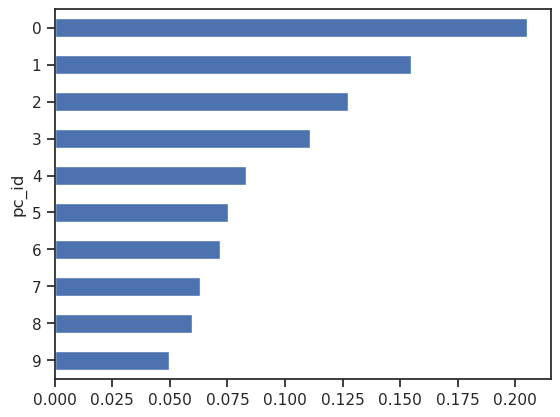

In [76]:
COMPINF.exp_var.sort_values().plot.barh();

In [77]:
DOC = pd.DataFrame(index=TFIDF.index).join(LIB)
DOC

title                        part  \
book_id chap_num                                                      
1       1         The Lord of the Rings  The Fellowship of the Ring   
        2         The Lord of the Rings  The Fellowship of the Ring   
        3         The Lord of the Rings  The Fellowship of the Ring   
        4         The Lord of the Rings  The Fellowship of the Ring   
        5         The Lord of the Rings  The Fellowship of the Ring   
...                                 ...                         ...   
6       5         The Lord of the Rings      The Return of the King   
        6         The Lord of the Rings      The Return of the King   
        7         The Lord of the Rings      The Return of the King   
        8         The Lord of the Rings      The Return of the King   
        9         The Lord of the Rings      The Return of the King   

                            author  year_of_publish  
book_id chap_num                                     
1       1         J. R. R. Tolkien  21 October 1954  
        2         J. R. R. Tolkien  21 October 1954  
        3         J. R. R. Tolkien  21 October 1954  
        4         J. R. R. Tolkien  21 October 1954  
        5         J. R. R. Tolkien  21 October 1954  
...                            ...              ...  
6       5         J. R. R. Tolkien   5 January 1956  
        6         J. R. R. Tolkien   5 January 1956  
        7         J. R. R. Tolkien   5 January 1956  
        8         J. R. R. Tolkien   5 January 1956  
        9         J. R. R. Tolkien   5 January 1956  

[62 rows x 4 columns]

In [78]:
DOC['label'] = DOC.apply(lambda x: f"{x['author'].title()} Book {x.name[0]} Ch{x.name[1]}", axis=1)
print(DOC)

                                  title                        part  \
book_id chap_num                                                      
1       1         The Lord of the Rings  The Fellowship of the Ring   
        2         The Lord of the Rings  The Fellowship of the Ring   
        3         The Lord of the Rings  The Fellowship of the Ring   
        4         The Lord of the Rings  The Fellowship of the Ring   
        5         The Lord of the Rings  The Fellowship of the Ring   
...                                 ...                         ...   
6       5         The Lord of the Rings      The Return of the King   
        6         The Lord of the Rings      The Return of the King   
        7         The Lord of the Rings      The Return of the King   
        8         The Lord of the Rings      The Return of the King   
        9         The Lord of the Rings      The Return of the King   

                            author  year_of_publish  \
book_id chap_num     

In [79]:
print(LOADINGS)

pc_id            0         1         2         3         4         5  \
term_str                                                               
fine     -0.000871  0.021445 -0.000992  0.012126 -0.034304 -0.003272   
worn     -0.002824 -0.003368 -0.004184 -0.006212 -0.001990  0.017796   
nice     -0.114280 -0.043761 -0.056330 -0.005842  0.004798 -0.016233   
remote   -0.014837 -0.005453 -0.006187 -0.011442  0.002521  0.007002   
horror   -0.003215 -0.012623 -0.005798 -0.002922  0.013686 -0.000637   
...            ...       ...       ...       ...       ...       ...   
steward   0.014684 -0.079191  0.107231  0.062996 -0.025954 -0.009596   
vague    -0.000154  0.027139  0.004622  0.000873 -0.002808  0.020039   
cloth     0.008587  0.007834  0.011190  0.011687  0.001532 -0.013081   
spirit    0.000485  0.000197  0.004050  0.014526 -0.001291  0.018786   
darkly    0.004386  0.006983 -0.005385 -0.000574  0.000436 -0.011574   

pc_id            6         7         8         9  
term_str    

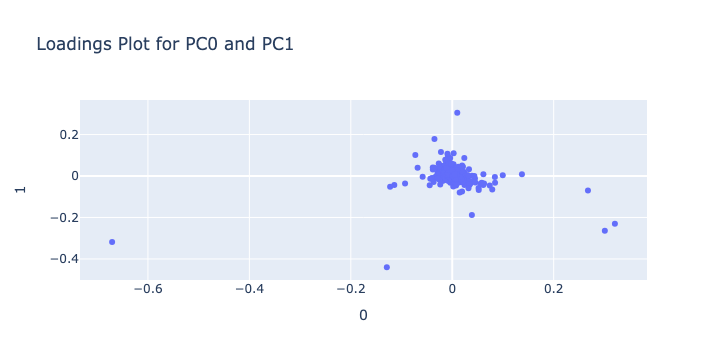

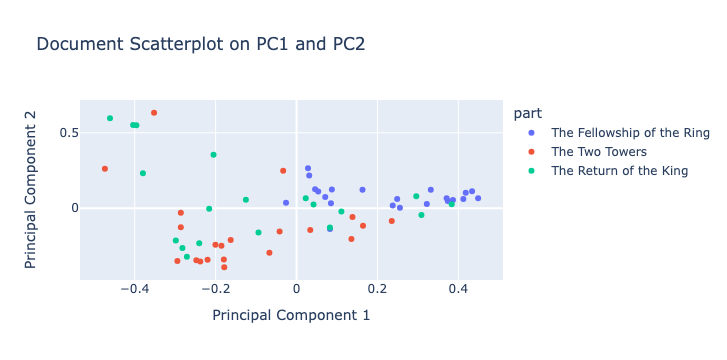

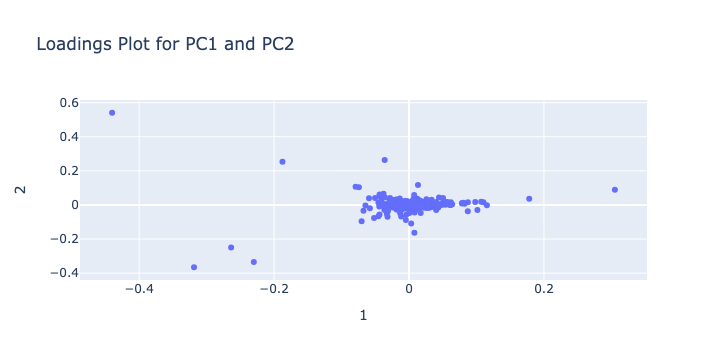

In [ ]:
import plotly.express as px

# Ensure the document metadata is correctly merged with DCM for coloring
DOC['PC0'] = DCM[0]
DOC['PC1'] = DCM[1]
DOC['PC2'] = DCM[2]
DOC['PC3'] = DCM[3]

# Visualization 1: First two principal components
fig_docs_1 = px.scatter(DOC, x='PC0', y='PC1', color='part',
                        labels={"PC0": "Principal Component 0", "PC1": "Principal Component 1"},
                        title="Document Scatterplot on PC0 and PC1")
fig_loadings_1 = px.scatter(LOADINGS, x=0, y=1,
                            labels={0: "PC0 Loadings", 1: "PC1 Loadings"},
                            title="Loadings Plot for PC0 and PC1")

# Visualization 2: Second and third principal components
fig_docs_2 = px.scatter(DOC, x='PC1', y='PC2', color='part',
                        labels={"PC1": "Principal Component 1", "PC2": "Principal Component 2"},
                        title="Document Scatterplot on PC1 and PC2")
fig_loadings_2 = px.scatter(LOADINGS, x=1, y=2,
                            labels={1: "PC1 Loadings", 2: "PC2 Loadings"},
                            title="Loadings Plot for PC1 and PC2")

# Display the figures
fig_docs_1.show()
fig_loadings_1.show()
fig_docs_2.show()
fig_loadings_2.show()

### In the first principal component (PC0), the polarity seems to reflect variations in the narrative or thematic content that distinctly separates the different parts of the "Lord of the Rings" series. The scatterplot on PC0 and PC1 shows that different books or parts of the series cluster separately along the PC0 axis. This suggests that PC0 may be capturing key differences in the story's progression or themes that are particular to each part, such as the introduction and development of key conflicts, settings, or character evolutions in "The Fellowship of the Ring," "The Two Towers," and "The Return of the King."

### The second principal component (PC1), when viewed against PC2, further differentiates elements within the books. This could be indicative of sub-themes or specific narrative techniques that vary more subtly throughout the series. For example, this might include the differentiation of scenes based on action versus dialogue, the presence of specific characters, or varying emotional tones. The dispersion along PC1 may relate to specific character developments or pivotal events that uniquely characterize the middle parts of the story, separating them from the beginning or the climactic endings.

## TOP 5 POSTIVE AND NEGATIVE TERMS FOR PC1 and PC2

In [81]:
top_5_positive_PC1 = LOADINGS.nlargest(5, 0).index.tolist()
top_5_negative_PC1 = LOADINGS.nsmallest(5, 0).index.tolist()
top_5_positive_PC2 = LOADINGS.nlargest(5, 1).index.tolist()
top_5_negative_PC2 = LOADINGS.nsmallest(5, 1).index.tolist()

print("Top 5 Positive Terms for PC1:", top_5_positive_PC1)
print("Top 5 Negative Terms for PC1:", top_5_negative_PC1)
print("Top 5 Positive Terms for PC2:", top_5_positive_PC2)
print("Top 5 Negative Terms for PC2:", top_5_negative_PC2)

Top 5 Positive Terms for PC1: ['théoden', 'éomer', 'gimli', 'saruman', 'isengard']
Top 5 Negative Terms for PC1: ['gollum', 'faramir', 'precious', 'nice', 'ã']
Top 5 Positive Terms for PC2: ['strider', 'bilbo', 'bag', 'pony', 'buckland']
Top 5 Negative Terms for PC2: ['faramir', 'gollum', 'éomer', 'théoden', 'denethor']


## LDA

- Table of document and topic concentrations.
- Table of topics and term counts, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

In [82]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [83]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 10
max_iter = 20
n_top_terms = 9
OHCO = ['book_id', 'chap_num', 'para_num']
PARA = OHCO[:3]
CHAP = OHCO[:2]
BOOK = OHCO[:1]

In [84]:
BAG = CHAP

In [85]:
TOKENS = pd.read_csv('CORPUS.csv')
TOKENS

book_id  chap_num  para_num  sent_num  token_num token_str  term_str  \
0             1         1         0         0          0   CHAPTER   chapter   
1             1         1         0         0          1       ONE       one   
2             1         1         0         0          2         A         a   
3             1         1         0         0          3      Long      long   
4             1         1         0         0          4  expected  expected   
...         ...       ...       ...       ...        ...       ...       ...   
474403        6         9        15        66          2         I         i   
474404        6         9        15        66          3         m         m   
474405        6         9        15        66          4      back      back   
474406        6         9        15        66          5        he        he   
474407        6         9        15        66          6     said.      said   

        pos pos_group            pos_tuple  
0        NN        NN    ('CHAPTER', 'NN')  
1        CD        CD        ('ONE', 'CD')  
2        DT        DT          ('A', 'DT')  
3        RB        RB       ('Long', 'RB')  
4       VBN        VB  ('expected', 'VBN')  
...     ...       ...                  ...  
474403  PRP        PR         ('I', 'PRP')  
474404   NN        NN          ('m', 'NN')  
474405   RB        RB       ('back', 'RB')  
474406  PRP        PR        ('he', 'PRP')  
474407   NN        NN      ('said.', 'NN')  

[474408 rows x 10 columns]

In [86]:
BAG

['book_id', 'chap_num']

In [87]:
TOKENS['term_str'] = TOKENS['term_str'].fillna('')  # Replace NaN with empty string
TOKENS['term_str'] = TOKENS['term_str'].astype(str)  # Ensure all entries are strings

# Now, create the document string DataFrame
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [88]:
# Remove 'chapter' followed by any numbers or words and potentially some spaces
DOCS['doc_str'] = DOCS['doc_str'].str.replace(r'\bchapter\b(?: \w+)?', '', regex=True)

# To clean up any additional whitespace that might be left after the removal
DOCS['doc_str'] = DOCS['doc_str'].str.strip()

DOCS.head(40)

doc_str
book_id chap_num                                                   
1       1         baggins bag end eleventy birthday party magnif...
        2         shadow past talk die ninety days disappearance...
        3         gandalf weeks frodo sign go know objected vani...
        4         mushrooms morning frodo woke refreshed bower l...
        5         home ourselves merry s something funny see wai...
        6         old frodo woke suddenly dark room merry candle...
        7         bombadil hobbits stone threshold stood blinkin...
        8         fog barrow downs night heard noises dreams tel...
        9         sign pony chief village land region island lan...
        10        strider frodo pippin way parlour light merry f...
        11        dark sleep inn darkness lay buckland mist stra...
        12        flight frodo desperately fire burning brightly...
2       1         frodo woke found bed thought slept dream edge ...
        2         council elrond day frodo woke well terraces lo...
        3         day hobbits held meeting bilbo s room merry pi...
        4         dark grey light fast night weary mountains dus...
        5         dëm company stood silent beside tomb balin fro...
        6         lothlãrien alas fear cannot stay longer aragor...
        7         mirror galadriel sun sinking mountains shadows...
        8         farewell lãrien night company chamber celeborn...
        9         great river frodo sam found tall grey trees co...
        10        fellowship right arm river side shadow tol bra...
3       1         boromir hill bent ground hobbits light footpri...
        2         riders rohan dusk deepened mist lay trees pale...
        3         hai pippin lay dark dream hear voice tunnels f...
        4         hobbits speed dark forest line stream westward...
        5         bones gimli arms feet last dawn companions bre...
        6         hall rode sunset dusk gathering night stiff we...
        7         helm s sun rode edoras light eyes fields rohan...
        8         road isengard light fair morning théoden ganda...
        9         flotsam jetsam gandalf s company rode eastward...
        10        voice saruman tunnel stood heap stones dark ro...
        11        palantír sun sinking arm mountains gandalf com...
4       1         master re fix mistake gamgee stood shoulders b...
        2         passage marshes gollum head neck thrust hands ...
        3         gate day journey mordor over marshes desert th...
        4         rabbit hours daylight left shade sun shadow ri...
        5         minutes awoke afternoon faramir back brought m...
        6         forbidden pool frodo woke faramir bending him ...
        7         journey cross roads frodo beds lay silence men...

In [89]:
## COUNT VECTOR SPACE
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [90]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [91]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
DTM

abandon  abide  aboard  abroad  absence  absurd  abyss  \
book_id chap_num                                                           
1       1               0      0       0       0        0       2      0   
        2               0      0       0       1        1       2      0   
        3               0      0       1       0        1       2      0   
        4               0      0       0       0        0       0      0   
        5               0      0       0       0        0       0      0   
...                   ...    ...     ...     ...      ...     ...    ...   
6       5               0      1       0       0        0       0      1   
        6               0      0       0       0        0       0      0   
        7               0      0       0       0        0       0      0   
        8               0      0       0       0        0       1      0   
        9               0      0       2       0        0       0      0   

                  accept  accident  account  ...  âomer  âowyn  âowyn faramir  \
book_id chap_num                             ...                                
1       1              0         1        0  ...      0      0              0   
        2              0         0        1  ...      0      0              0   
        3              0         0        0  ...      0      0              0   
        4              0         2        0  ...      0      0              0   
        5              0         0        3  ...      0      0              0   
...                  ...       ...      ...  ...    ...    ...            ...   
6       5              0         0        0  ...      5     28              5   
        6              0         0        1  ...     14     10              0   
        7              0         0        1  ...      0      0              0   
        8              0         0        0  ...      0      0              0   
        9              0         0        0  ...      0      0              0   

                  âowyn rohan  éomer  éomer king  éomer son  éomund  éored  \
book_id chap_num                                                             
1       1                   0      0           0          0       0      0   
        2                   0      0           0          0       0      0   
        3                   0      0           0          0       0      0   
        4                   0      0           0          0       0      0   
        5                   0      0           0          0       0      0   
...                       ...    ...         ...        ...     ...    ...   
6       5                   6      0           0          0       0      0   
        6                   0      0           0          0       0      0   
        7                   0      0           0          0       0      0   
        8                   0      0           0          0       0      0   
        9                   0      0           0          0       0      0   

                  éowyn  
book_id chap_num         
1       1             0  
        2             0  
        3             0  
        4             0  
        5             0  
...                 ...  
6       5             0  
        6             0  
        7             0  
        8             0  
        9             0  

[62 rows x 4000 columns]

In [92]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

VOCAB

doc_count
term_str             
abandon             5
abide               9
aboard              4
abroad              8
absence             6
...               ...
éomer king          5
éomer son           5
éomund              7
éored               2
éowyn               6

[4000 rows x 1 columns]

In [93]:
DOCS.term_count.describe()

count      62.000000
mean     2092.048387
std       697.513322
min       997.000000
25%      1532.000000
50%      1965.500000
75%      2464.500000
max      4221.000000
Name: term_count, dtype: float64

## GENERATE MODEL
### LDA THETA

In [94]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]
lda_model = lda_engine.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES
colors = 'YlGnBu'
THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

### LDA PHI

In [95]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [96]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

## CREATE TOPICS and get TOP TERMS per topic

In [97]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

TOPICS

top_terms
topic_id                                                   
T00       frodo bilbo don merry hobbits shire end ll pippin
T01       brook way ll blinking longing said farewell ha...
T02       frodo light dark trees water way gandalf road ...
T03       men lord éomer théoden king legolas gimli gand...
T04       pippin gandalf merry treebeard time saruman en...
T05       gandalf elrond power frodo mordor saruman saur...
T06       gandalf gimli saruman legolas said aragorn tim...
T07        gollum frodo way smãagol master yes eyes dark ll
T08       faramir frodo men said gondor days boromir lor...
T09                frodo orc ll ve hand orcs tower dark sam

In [98]:
# TOP 5 TOPICS and TOP 5 WORDS

import pandas as pd

# Assuming TOPICS is loaded as shown above

# Display the top 5 words for each of the first five topics and assign labels
topic_labels = {
    'T00': 'Siege of Gondor',
    'T01': 'Orcs and Captivity',
    'T02': 'Frodo\'s Journey',
    'T03': 'Fellowship and Conflict',
    'T04': 'Hobbits\' Adventure'
}

# Extract top 5 terms for easier viewing and labeling
for topic, label in topic_labels.items():
    top_terms = TOPICS.loc[topic, 'top_terms'].split()[:5]  # Assuming top_terms are space-separated
    print(f"– {topic} ({label}): {', '.join(top_terms)}")


– T00 (Siege of Gondor): frodo, bilbo, don, merry, hobbits
– T01 (Orcs and Captivity): brook, way, ll, blinking, longing
– T02 (Frodo's Journey): frodo, light, dark, trees, water
– T03 (Fellowship and Conflict): men, lord, éomer, théoden, king
– T04 (Hobbits' Adventure): pippin, gandalf, merry, treebeard, time


### SORT TOPICS BY WEIGHT

In [99]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='top_terms', figsize=(5, n_topics/2));

In [100]:
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

## 8.9 LDA + PCA Viz

In [101]:
LIB_2 = pd.read_csv('LIB.csv')
LIB_2

book_id                  title                        part  \
0        1  The Lord of the Rings  The Fellowship of the Ring   
1        2  The Lord of the Rings  The Fellowship of the Ring   
2        3  The Lord of the Rings              The Two Towers   
3        4  The Lord of the Rings              The Two Towers   
4        5  The Lord of the Rings      The Return of the King   
5        6  The Lord of the Rings      The Return of the King   

             author  year_of_publish  
0  J. R. R. Tolkien  21 October 1954  
1  J. R. R. Tolkien  21 October 1954  
2  J. R. R. Tolkien    21 April 1955  
3  J. R. R. Tolkien    21 April 1955  
4  J. R. R. Tolkien   5 January 1956  
5  J. R. R. Tolkien   5 January 1956

In [103]:
print(LIB_2.columns)

Index(['book_id', 'title', 'part', 'author', 'year_of_publish'], dtype='object')


In [104]:
import pandas as pd # Put here again in case we copy into a separate file
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
#import plotly_express as px

class TopicExplorer:
    
    n_features = 4000
    stopwords = 'english'
    lda_num_topics = 20
    lda_max_iter = 20
    lda_n_top_terms = 7
    
    def __init__(self, tokens_df, lib_df, bag, labels=[]):
        self.TOKENS = tokens_df
        self.LIB = lib_df
        self.bag = bag
        self.labels = labels
        
    def generate_tables(self):
        print("BAG:", self.bag[-1])
        print("LABELS:", self.labels)
        print("Getting DOCS")
        self._get_docs()
        print("Getting TERMS")
        self._get_count_model()
        print("Getting THETA, PHI")
        self._get_topic_model()
        print("Getting TOPICS")
        self._get_topics()
        print('Binding LIB labels to THETA')
        self._bind_labels()
        print("Done.")
        return self
        
    def _get_docs(self, pos_remove_pat=r'^NNS?$'):
        self.DOCS = self.TOKENS[self.TOKENS.pos.str.match(pos_remove_pat)]\
            .groupby(self.bag).term_str\
            .apply(lambda x: ' '.join(x))\
            .to_frame()\
            .rename(columns={'term_str':'doc_str'})
        
    def _get_count_model(self):
        self.count_engine = CountVectorizer(max_features=self.n_features, 
                                            stop_words=self.stopwords)
        self.count_model = self.count_engine.fit_transform(self.DOCS.doc_str)
        self.TERMS = self.count_engine.get_feature_names_out()
        
    def _get_topic_model(self):
        self.lda_engine = LDA(n_components=self.lda_num_topics, 
                              max_iter=self.lda_max_iter, 
                              learning_offset=50., 
                              random_state=0)
        self.THETA = pd.DataFrame(self.lda_engine.fit_transform(self.count_model), 
                                  index=self.DOCS.index)
        self.THETA.columns.name = 'topic_id'
        self.PHI = pd.DataFrame(self.lda_engine.components_, columns=self.TERMS)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
    def _get_topics(self, n_terms=10):
        self.TOPICS = self.PHI.stack().to_frame('weight')\
            .groupby('topic_id')\
            .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(self.lda_n_top_terms)\
               .reset_index()\
               .drop('topic_id', axis=1)\
               .term_str)
        self.TOPICS['label'] = self.TOPICS[[t for t in range(self.lda_n_top_terms)]]\
            .apply(lambda x: str(x.name)\
                   .zfill(len(str(self.lda_num_topics))) + ' ' + ' '.join(x), axis=1)
        self.TOPICS['doc_weight_sum'] = self.THETA.sum()
        self.topic_cols = [t for t in range(self.lda_num_topics)]
        
    def _bind_labels(self):
        self.LABELS = {}
        self.LABEL_VALUES = {}
        for label in self.labels:
            self.THETA[label] = self.THETA\
                .apply(lambda x: self.LIB.loc[x.name[0], label], axis=1)
            self.LABELS[label] = self.THETA.groupby(label)[self.topic_cols].mean().T  
            self.THETA = self.THETA.drop(label, axis=1) # Don't keep the column
            self.LABELS[label].index.name = 'topic_id'
            self.LABELS[label]['label'] = self.TOPICS['label']
            self.LABEL_VALUES[label] = sorted(list(set(self.LIB[label])))
            
    def show_dominant_label_topic(self, label):
        X = self.LABELS[label][self.LABEL_VALUES[label]].idxmax()
        return X.to_frame('topic_id').topic_id.map(self.TOPICS.label)
            
    def show_label_values(self):
        for label in self.LABEL_VALUES:
            print(label, ": ", self.LABEL_VALUES[label])
        
    def show_topic_bar(self):
        fig_height = self.lda_num_topics / 3
        self.TOPICS.sort_values('doc_weight_sum', ascending=True)\
            .plot.barh(y='doc_weight_sum', x='label', figsize=(5, fig_height));
        
    def show_topic_label_heatmap(self, label):
        return MP.LABELS[label][MP.LABEL_VALUES[label]].style.background_gradient()
        
    def show_label_comparison_plot(self, label, label_value_x, label_value_y):
        px.scatter(self.LABELS[label].reset_index(), label_value_x, label_value_y, 
                   hover_name='label', text='topic_id', width=800, height=600)\
            .update_traces(mode='text').show()        


In [105]:
topic_explorer = TopicExplorer(TOKENS, LIB, bag=['chap_num','para_num'], labels=[])

# LDA THETA and PHI
topic_explorer.generate_tables()

lda_theta = topic_explorer.THETA
lda_phi = topic_explorer.PHI

BAG: para_num
LABELS: []
Getting DOCS
Getting TERMS
Getting THETA, PHI
Getting TOPICS
Binding LIB labels to THETA
Done.


In [107]:
phi_scaled
phi_pca
mean_doc_weight

topic_id
0     0.027936
1     0.016142
2     0.027114
3     0.103599
4     0.026511
5     0.080220
6     0.046616
7     0.019644
8     0.008688
9     0.029261
10    0.017292
11    0.027698
12    0.014796
13    0.182512
14    0.052558
15    0.021082
16    0.029738
17    0.098618
18    0.125222
19    0.044754
dtype: float64

In [106]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

scaler = StandardScaler()
phi_scaled = scaler.fit_transform(topic_explorer.PHI)

pca = PCA(n_components=2)
phi_pca = pca.fit_transform(phi_scaled)

mean_doc_weight = topic_explorer.THETA.mean()

plt.figure(figsize=(8, 8))
for i, topic in enumerate(topic_explorer.PHI.index):
    x, y = phi_pca[i]
    plt.scatter(x, y, s=mean_doc_weight[topic] * 100, label=f'Topic {i}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of LDA Topics')
plt.show()


#### The axes represent the two principal components derived from the PCA. These components are linear combinations of the original terms in the topics that capture the maximum variance in the data. The first component (x-axis) captures the most variance, and the second component (y-axis) captures the next most. Topics that are close together on the plot share similar term distributions, indicating thematic similarities. Topics that are far apart are thematically different. The outlier topics (those far from the cluster centers) likely represent unique themes that are not widely covered in the dataset. Larger points (e.g., topics 3, 5, 13, 17, 18) indicate topics with a higher average presence across documents, suggesting these themes are more common or discussed more frequently within the corpus.Smaller points indicate less prevalent topics, which might be more specialized or niche.

## Word Embedding + SA
- Terms and embeddings, either added to the VOCAB table or as a separate table with a shared index with the VOCAB table.

- Sentiment and emotion values as features in VOCAB or as a separate table with a shared index with the VOCAB table.
- Sentiment polarity and emotions for each document.

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
from IPython.display import display, HTML

In [111]:
# For TOKENS
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1]
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

In [112]:
TOKENS = pd.read_csv('CORPUS.csv').set_index(OHCO).sort_index()
VOCAB = pd.read_csv('VOCAB.csv').set_index('term_str').sort_index()
LIB = pd.read_csv('LIB.csv').set_index('book_id')[['author','title']].sort_index()
BOW = pd.read_csv('BOW_2.csv').set_index(['book_id','chap_num','term_str']).sort_index()

In [113]:
BOW

n     tfidf
book_id chap_num term_str              
1       1        111        1  0.000593
                 130        1  0.000593
                 22nd       2  0.001186
                 3          1  0.000593
                 33         1  0.000593
...                        ..       ...
6       9        you       54  0.000000
                 young      4  0.000618
                 your       8  0.000079
                 yule       2  0.002472
                 ã          1  0.000260

[91957 rows x 2 columns]

In [114]:
LIB['author_id'] = LIB.author.str.split(', ').str[0]
LIB['title_short'] = LIB.author_id + ' ' + LIB.index.astype('str') + ': ' + LIB.title.str[:25]
LIB

author                  title         author_id  \
book_id                                                              
1        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
2        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
3        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
4        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
5        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
6        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   

                                       title_short  
book_id                                             
1        J. R. R. Tolkien 1: The Lord of the Rings  
2        J. R. R. Tolkien 2: The Lord of the Rings  
3        J. R. R. Tolkien 3: The Lord of the Rings  
4        J. R. R. Tolkien 4: The Lord of the Rings  
5        J. R. R. Tolkien 5: The Lord of the Rings  
6        J. R. R. Tolkien 6: The Lord of the Rings

## Sentiment VOCAB_SENT

In [115]:
SALEX = pd.read_csv('salex_nrc.csv').set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [116]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)
V

n         p          i      dfidf porter_stem max_pos  \
term_str                                                              
abandon       7  0.000015  16.048414  18.161341     abandon      NN   
abandoned     3  0.000006  17.270806  13.107701     abandon     VBN   
abominable    6  0.000013  16.270806  20.215403      abomin      JJ   
absence       7  0.000015  16.048414  20.215403      absenc      NN   
abundant      1  0.000002  18.855769   5.954196       abund      NN   
...         ...       ...        ...        ...         ...     ...   
yearning      1  0.000002  18.855769   5.954196       yearn     VBG   
yell         12  0.000025  15.270806  25.058442        yell      NN   
yelp          4  0.000008  16.855769  13.107701        yelp      NN   
young       121  0.000255  11.936906  27.555489       young      JJ   
youth        11  0.000023  15.396337  26.322682       youth      NN   

           max_pos_group  stop  anger  anticipation  disgust  fear  joy  \
term_str                                                                  
abandon               NN     0      0             0        0     1    0   
abandoned             VB     0      1             0        0     1    0   
abominable            JJ     0      0             0        1     1    0   
absence               NN     0      0             0        0     1    0   
abundant              NN     0      0             0        0     0    1   
...                  ...   ...    ...           ...      ...   ...  ...   
yearning              VB     0      0             1        0     0    1   
yell                  NN     0      1             0        0     1    0   
yelp                  NN     0      1             0        0     1    0   
young                 JJ     0      0             1        0     0    1   
youth                 NN     0      1             1        0     1    1   

            negative  positive  sadness  surprise  trust  sentiment  
term_str                                                             
abandon            1         0        1         0      0         -1  
abandoned          1         0        1         0      0         -1  
abominable         1         0        0         0      0         -1  
absence            1         0        1         0      0         -1  
abundant           0         1        0         0      0          1  
...              ...       ...      ...       ...    ...        ...  
yearning           1         1        0         0      1          0  
yell               1         0        0         1      0         -1  
yelp               1         0        0         1      0         -1  
young              0         1        0         1      0          1  
youth              0         1        0         1      0          1  

[1463 rows x 19 columns]

In [117]:
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

### Merge Vocab with BOW

In [118]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [119]:
BOW_SENT = BOW.join(V[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()
BOW_SENT

n     tfidf max_pos  anger  anticipation  \
book_id chap_num term_str                                               
1       1        abominable  1  0.000336      JJ    0.0           0.0   
                 abundant    1  0.000593      NN    0.0           0.0   
                 accident    1  0.000336      NN    0.0           0.0   
                 accusing    1  0.000593     VBG    1.0           0.0   
                 admirable   1  0.000435      JJ    0.0           0.0   
...                         ..       ...     ...    ...           ...   
6       9        wonderful   2  0.000850      NN    0.0           0.0   
                 word        1  0.000077      NN    0.0           0.0   
                 words       1  0.000030     NNS    1.0           0.0   
                 worn        1  0.000297      NN    0.0           0.0   
                 young       4  0.000618      JJ    0.0           1.0   

                             disgust  fear  joy  sadness  surprise  trust  \
book_id chap_num term_str                                                   
1       1        abominable      1.0   1.0  0.0      0.0       0.0    0.0   
                 abundant        0.0   0.0  1.0      0.0       0.0    0.0   
                 accident        0.0   1.0  0.0      1.0       1.0    0.0   
                 accusing        0.0   1.0  0.0      0.0       0.0    0.0   
                 admirable       0.0   0.0  1.0      0.0       0.0    1.0   
...                              ...   ...  ...      ...       ...    ...   
6       9        wonderful       0.0   0.0  1.0      0.0       1.0    1.0   
                 word            0.0   0.0  0.0      0.0       0.0    1.0   
                 words           0.0   0.0  0.0      0.0       0.0    0.0   
                 worn            0.0   0.0  0.0      1.0       0.0    0.0   
                 young           0.0   0.0  1.0      0.0       1.0    0.0   

                             sentiment  
book_id chap_num term_str               
1       1        abominable       -1.0  
                 abundant          1.0  
                 accident         -1.0  
                 accusing         -1.0  
                 admirable         1.0  
...                                ...  
6       9        wonderful         1.0  
                 word              1.0  
                 words            -1.0  
                 worn             -1.0  
                 young             1.0  

[11916 rows x 12 columns]

In [120]:
CORPUS = pd.read_csv('CORPUS.csv')

In [121]:
# DOC_SENT
import gensim

BAG = OHCO[:1] # BOOKS
DOCS = CORPUS.groupby(BAG)


def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument([str(w) for w in list_of_words], [i])
data = DOCS.term_str.apply(lambda x: list(x)).to_list()
data_for_training = list(tagged_document(data))
data_for_training[5][1]


[5]

In [122]:
data = DOCS.term_str.apply(lambda x: list(x)).to_list()

In [123]:
data_for_training = list(tagged_document(data))
data_for_training[5][1]

[5]

In [172]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)

In [173]:
model.build_vocab(data_for_training)

In [174]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [175]:
LIB

author                  title         author_id  \
book_id                                                              
1        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
2        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
3        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
4        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
5        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   
6        J. R. R. Tolkien  The Lord of the Rings  J. R. R. Tolkien   

                                       title_short  
book_id                                             
1        J. R. R. Tolkien 1: The Lord of the Rings  
2        J. R. R. Tolkien 2: The Lord of the Rings  
3        J. R. R. Tolkien 3: The Lord of the Rings  
4        J. R. R. Tolkien 4: The Lord of the Rings  
5        J. R. R. Tolkien 5: The Lord of the Rings  
6        J. R. R. Tolkien 6: The Lord of the Rings

In [176]:
DOC_SENT = pd.DataFrame( model.dv.get_normed_vectors(), index=LIB.title_short)

In [177]:
DOC_SENT

0         1         2   \
title_short                                                               
J. R. R. Tolkien 1: The Lord of the Rings -0.207357 -0.019248 -0.064062   
J. R. R. Tolkien 2: The Lord of the Rings -0.203404 -0.361437  0.090557   
J. R. R. Tolkien 3: The Lord of the Rings -0.043518  0.078900 -0.201932   
J. R. R. Tolkien 4: The Lord of the Rings  0.088750  0.098346 -0.390647   
J. R. R. Tolkien 5: The Lord of the Rings  0.040525 -0.023489 -0.132374   
J. R. R. Tolkien 6: The Lord of the Rings -0.227099 -0.120492 -0.153095   

                                                 3         4         5   \
title_short                                                               
J. R. R. Tolkien 1: The Lord of the Rings  0.145202 -0.061865  0.014586   
J. R. R. Tolkien 2: The Lord of the Rings -0.137701 -0.056792 -0.142347   
J. R. R. Tolkien 3: The Lord of the Rings -0.071905  0.106621  0.028913   
J. R. R. Tolkien 4: The Lord of the Rings  0.260856 -0.179176  0.108861   
J. R. R. Tolkien 5: The Lord of the Rings -0.047747  0.272464 -0.137384   
J. R. R. Tolkien 6: The Lord of the Rings  0.241608  0.134800 -0.055599   

                                                 6         7         8   \
title_short                                                               
J. R. R. Tolkien 1: The Lord of the Rings -0.049591  0.031022 -0.271107   
J. R. R. Tolkien 2: The Lord of the Rings -0.131258 -0.069415 -0.035449   
J. R. R. Tolkien 3: The Lord of the Rings  0.045337 -0.068882  0.043550   
J. R. R. Tolkien 4: The Lord of the Rings -0.178100  0.012518 -0.100721   
J. R. R. Tolkien 5: The Lord of the Rings -0.194556 -0.179003 -0.110693   
J. R. R. Tolkien 6: The Lord of the Rings  0.173948  0.033678  0.025623   

                                                 9   ...        30        31  \
title_short                                          ...                       
J. R. R. Tolkien 1: The Lord of the Rings  0.107966  ...  0.242327  0.023281   
J. R. R. Tolkien 2: The Lord of the Rings -0.131023  ... -0.025350  0.013012   
J. R. R. Tolkien 3: The Lord of the Rings  0.168533  ...  0.325664 -0.116933   
J. R. R. Tolkien 4: The Lord of the Rings -0.002176  ...  0.199309  0.070938   
J. R. R. Tolkien 5: The Lord of the Rings  0.101754  ...  0.055854  0.045015   
J. R. R. Tolkien 6: The Lord of the Rings -0.036216  ...  0.196651  0.161083   

                                                 32        33        34  \
title_short                                                               
J. R. R. Tolkien 1: The Lord of the Rings -0.126313  0.156899 -0.073569   
J. R. R. Tolkien 2: The Lord of the Rings -0.246978 -0.241416 -0.167897   
J. R. R. Tolkien 3: The Lord of the Rings -0.284590 -0.216867  0.176940   
J. R. R. Tolkien 4: The Lord of the Rings  0.187099 -0.132689  0.116874   
J. R. R. Tolkien 5: The Lord of the Rings -0.098226 -0.037701 -0.069975   
J. R. R. Tolkien 6: The Lord of the Rings  0.210160 -0.382581 -0.016465   

                                                 35        36        37  \
title_short                                                               
J. R. R. Tolkien 1: The Lord of the Rings  0.091411  0.142488 -0.162485   
J. R. R. Tolkien 2: The Lord of the Rings  0.261436  0.030602 -0.322946   
J. R. R. Tolkien 3: The Lord of the Rings -0.211013 -0.153280 -0.280352   
J. R. R. Tolkien 4: The Lord of the Rings  0.053889  0.124425 -0.055967   
J. R. R. Tolkien 5: The Lord of the Rings -0.032089  0.189210 -0.396345   
J. R. R. Tolkien 6: The Lord of the Rings  0.180214 -0.081321 -0.101022   

                                                 38        39  
title_short                                                    
J. R. R. Tolkien 1: The Lord of the Rings -0.059547 -0.044802  
J. R. R. Tolkien 2: The Lord of the Rings -0.063987 -0.028509  
J. R. R. Tolkien 3: The Lord of the Rings  0.005581  0.020239  
J. R. R. Tolkien 4: The Lord of the Rings -0.147647  0.026281  
J. R. R. Tolkien 5:

In [128]:
print(LIB.columns)

Index(['author', 'title', 'author_id', 'title_short'], dtype='object')


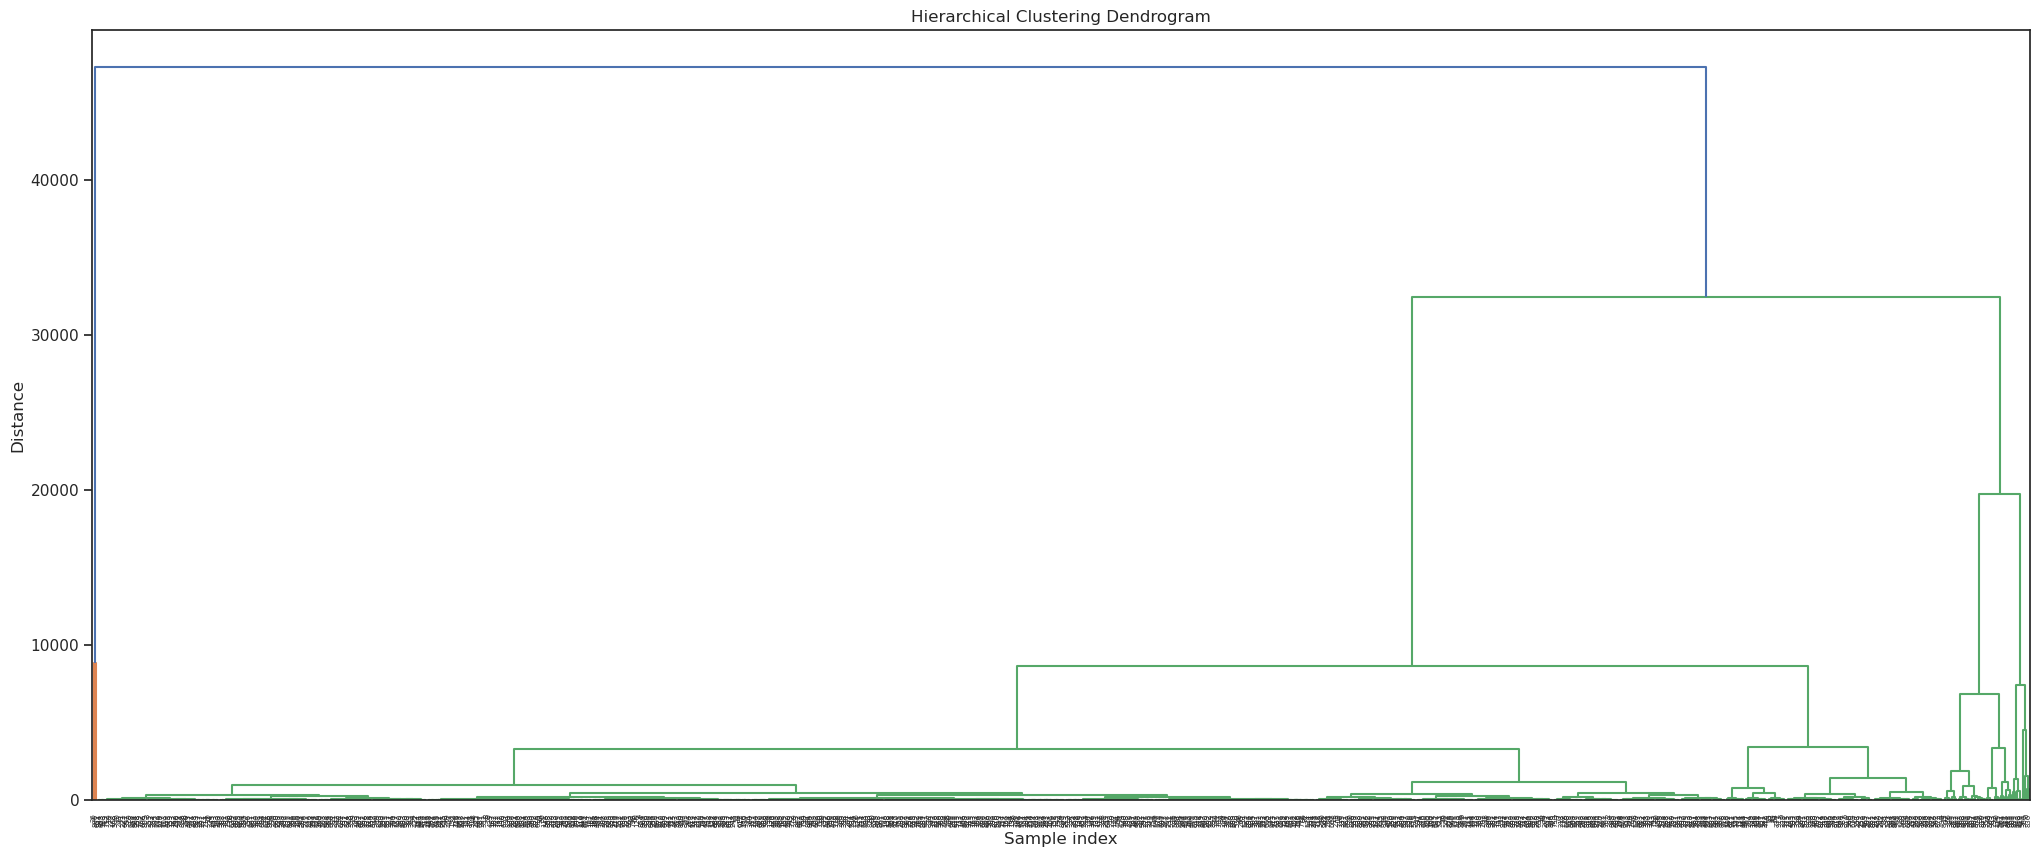

In [170]:
import pandas as pd

# Convert categorical data using one-hot encoding or similar methods
if X.select_dtypes(include=['object']).empty is False:
    X_encoded = pd.get_dummies(X)
else:
    X_encoded = X.copy()

# Check for missing values and fill or drop them
X_encoded.fillna(method='ffill', inplace=True)  # or use dropna()


import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix
Z = linkage(X_encoded, 'ward')

# Plot the dendrogram
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [130]:
for col in emo_cols:
    BOW_SENT[col] = BOW_SENT[col] * BOW_SENT.tfidf

In [131]:
BOW_SENT.head()

n     tfidf max_pos     anger  anticipation  \
book_id chap_num term_str                                                  
1       1        abominable  1  0.000336      JJ  0.000000           0.0   
                 abundant    1  0.000593      NN  0.000000           0.0   
                 accident    1  0.000336      NN  0.000000           0.0   
                 accusing    1  0.000593     VBG  0.000593           0.0   
                 admirable   1  0.000435      JJ  0.000000           0.0   

                              disgust      fear       joy   sadness  surprise  \
book_id chap_num term_str                                                       
1       1        abominable  0.000336  0.000336  0.000000  0.000000  0.000000   
                 abundant    0.000000  0.000000  0.000593  0.000000  0.000000   
                 accident    0.000000  0.000336  0.000000  0.000336  0.000336   
                 accusing    0.000000  0.000593  0.000000  0.000000  0.000000   
                 admirable   0.000000  0.000000  0.000435  0.000000  0.000000   

                                trust  sentiment  
book_id chap_num term_str                         
1       1        abominable  0.000000  -0.000336  
                 abundant    0.000000   0.000593  
                 accident    0.000000  -0.000336  
                 accusing    0.000000  -0.000593  
                 admirable   0.000435   0.000435

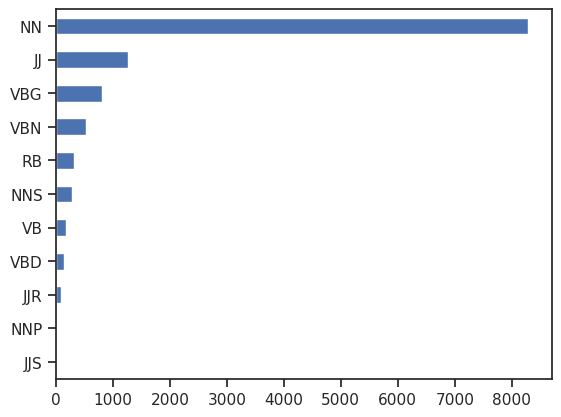

In [132]:
BOW_SENT.max_pos.value_counts().sort_values().plot.barh();

In [133]:
EMO_BOOKS = BOW_SENT.groupby(['book_id'])[emo_cols].mean()
EMO_CHAPS = BOW_SENT.groupby(['book_id','chap_num'])[emo_cols].mean()

In [134]:
EMO_BOOKS.index = LIB.title_short #book_title

In [135]:
EMO_BOOKS.plot.barh(figsize=(15,30));

In [136]:
LOTR_chaps = EMO_CHAPS
LOTR_chaps.style.background_gradient(cmap='YlGnBu', axis=None)

In [137]:
book_id = 1  # or whatever book ID you need
LOTR_chaps_thin = EMO_CHAPS.stack().to_frame().reset_index().rename(columns={0: 'value', 'level_2': 'emo'})
LOTR_chaps_thin = LOTR_chaps_thin[LOTR_chaps_thin['book_id'] == book_id]

In [138]:
LOTR_chaps_thin

book_id  chap_num           emo     value
0          1         1         anger  0.000092
1          1         1  anticipation  0.000170
2          1         1       disgust  0.000074
3          1         1          fear  0.000089
4          1         1           joy  0.000194
..       ...       ...           ...       ...
103        1        12           joy  0.000061
104        1        12       sadness  0.000136
105        1        12      surprise  0.000046
106        1        12         trust  0.000072
107        1        12     sentiment -0.000152

[108 rows x 4 columns]

In [139]:
def plot_sentiments(df, emo='sentiment'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

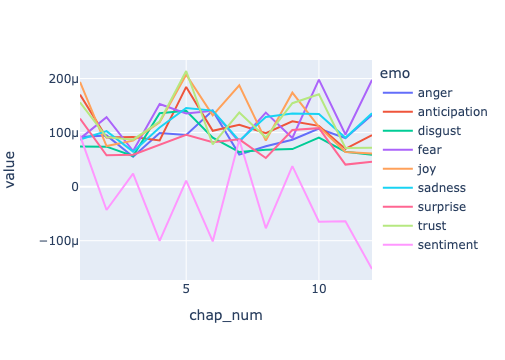

In [140]:
px.line(LOTR_chaps_thin, x='chap_num', y='value', color='emo')

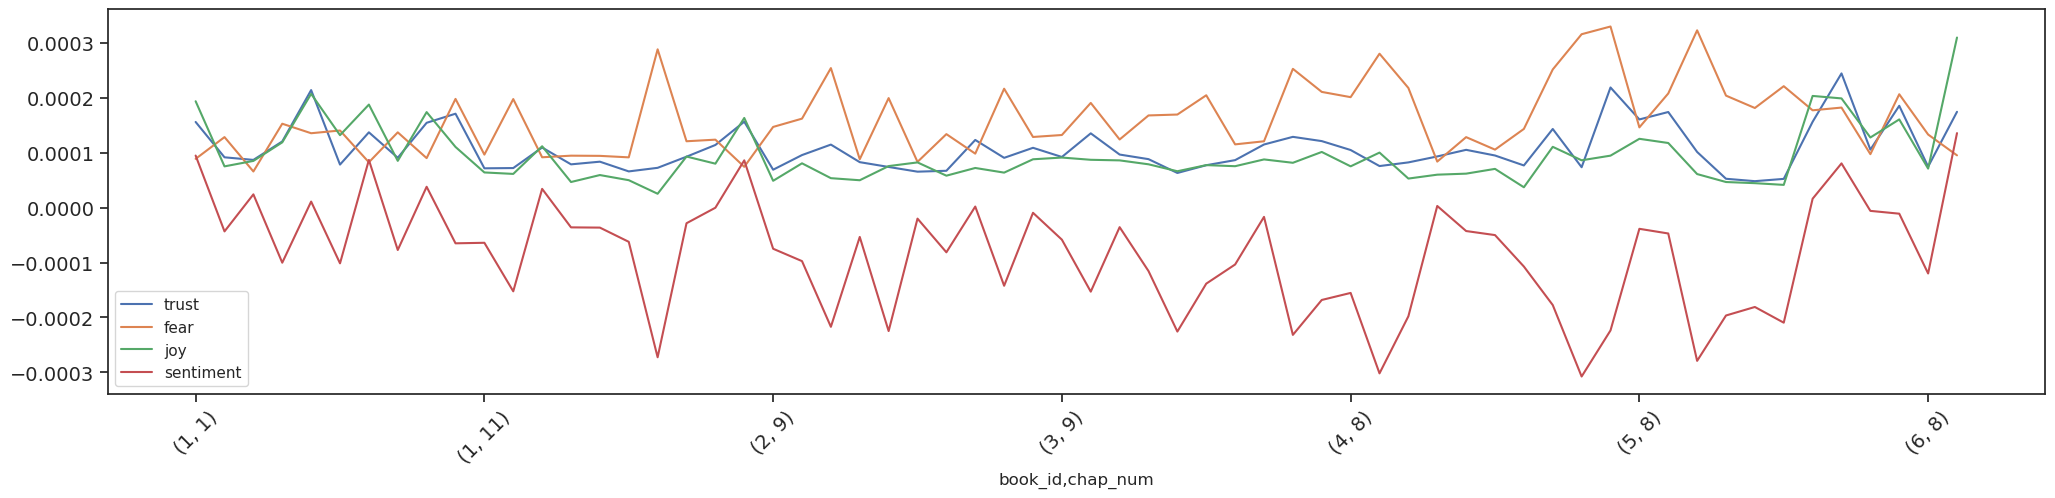

In [141]:
plot_sentiments(LOTR_chaps, ['trust','fear','joy','sentiment'])

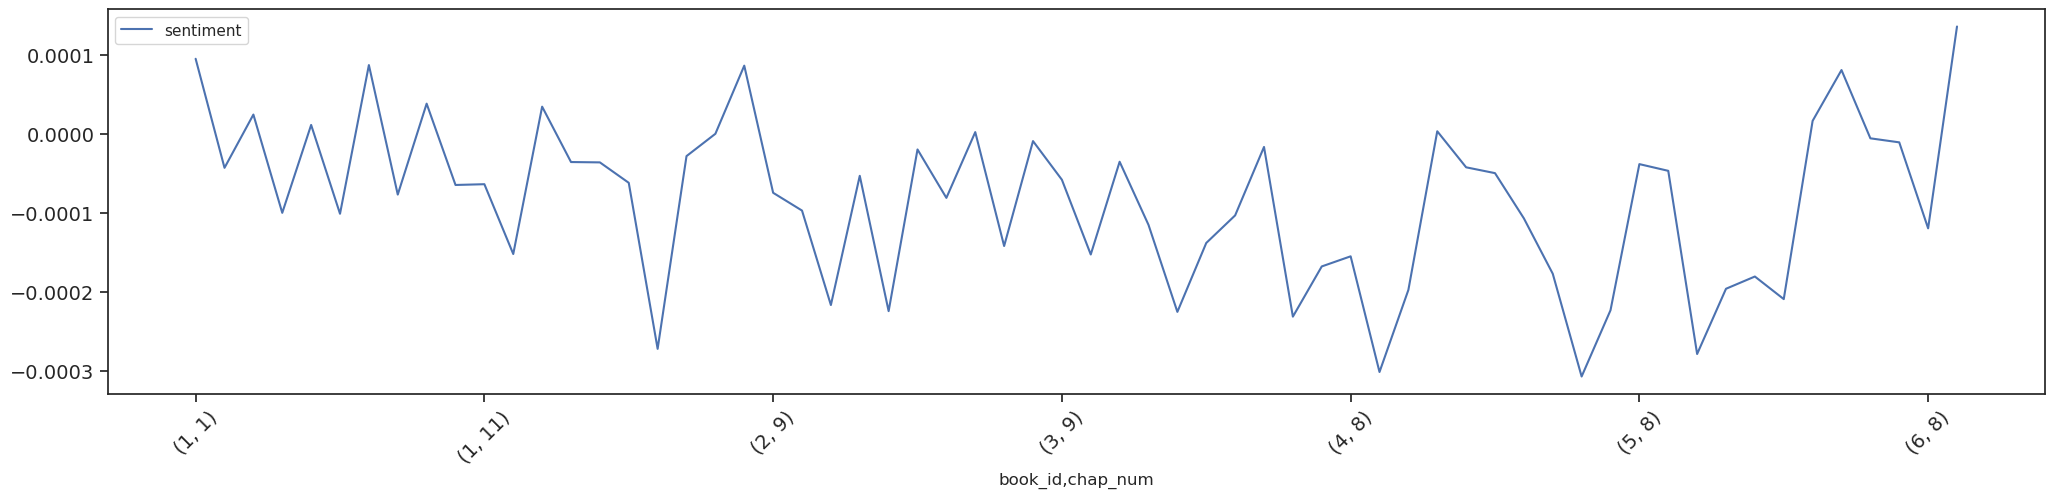

In [142]:
plot_sentiments(LOTR_chaps, ['sentiment'])

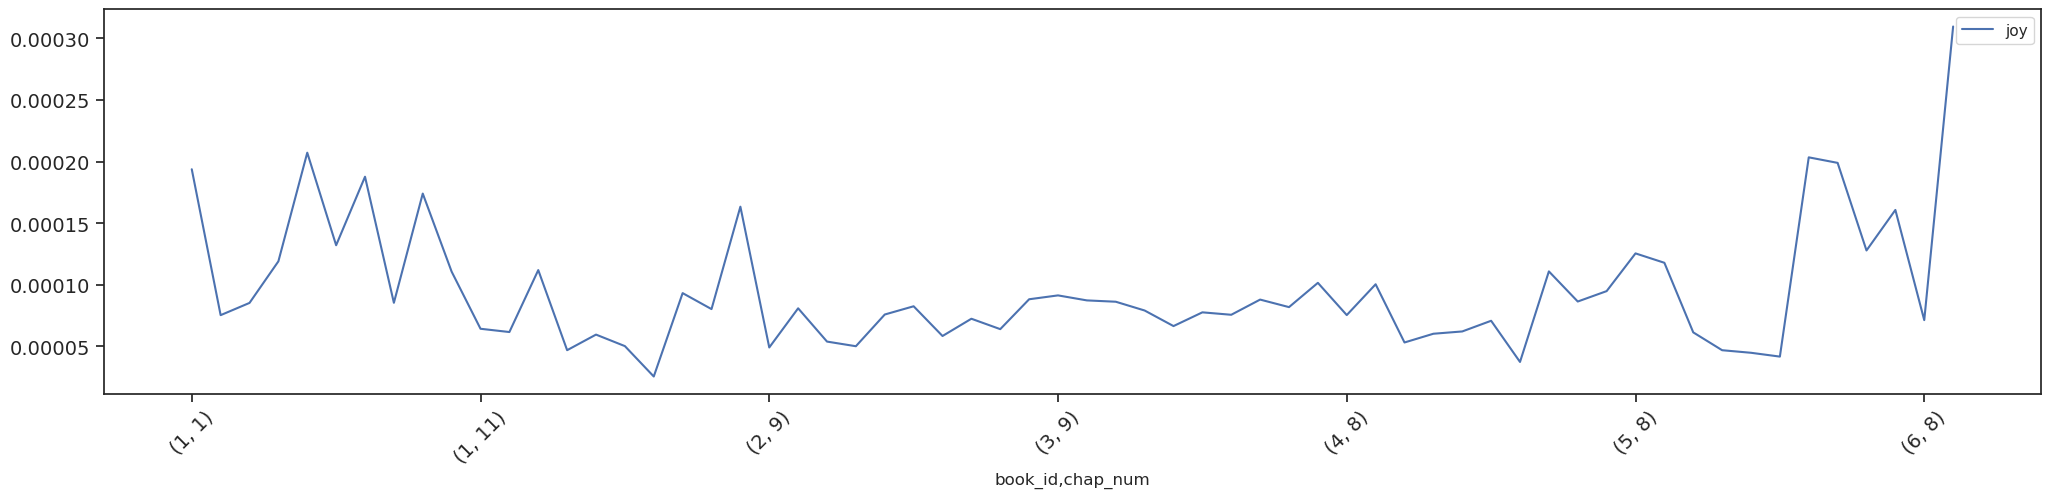

In [143]:
plot_sentiments(LOTR_chaps, ['joy'])

## VOCAB_W2V

In [144]:
data_prefix = 'novels'
OHCO = ['book_id', 'chapter_num', 'para_num', 'sent_num', 'token_num']
PARA = OHCO[:4] # Paragraphs
SENT = OHCO[:5] # Sentences
BAG = PARA

In [145]:
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [146]:
TOKENS

token_str  term_str  pos  \
book_id chap_num para_num sent_num token_num                            
1       1        0        0        0           CHAPTER   chapter   NN   
                                   1               ONE       one   CD   
                                   2                 A         a   DT   
                                   3              Long      long   RB   
                                   4          expected  expected  VBN   
...                                                ...       ...  ...   
6       9        15       66       2                 I         i  PRP   
                                   3                 m         m   NN   
                                   4              back      back   RB   
                                   5                he        he  PRP   
                                   6             said.      said   NN   

                                             pos_group            pos_tuple  
book_id chap_num para_num sent_num token_num                                 
1       1        0        0        0                NN    ('CHAPTER', 'NN')  
                                   1                CD        ('ONE', 'CD')  
                                   2                DT          ('A', 'DT')  
                                   3                RB       ('Long', 'RB')  
                                   4                VB  ('expected', 'VBN')  
...                                                ...                  ...  
6       9        15       66       2                PR         ('I', 'PRP')  
                                   3                NN          ('m', 'NN')  
                                   4                RB       ('back', 'RB')  
                                   5                PR        ('he', 'PRP')  
                                   6                NN      ('said.', 'NN')  

[474408 rows x 5 columns]

In [147]:
VOCAB = VOCAB[~VOCAB.index.isna()] # There is NaN in the index for some reason

In [148]:
VOCAB.sample(5)

n         p          i      dfidf porter_stem max_pos  \
term_str                                                            
howling    19  0.000040  14.607841  27.442412        howl     VBG   
union       1  0.000002  18.855769   5.954196       union      NN   
dish        4  0.000008  16.855769   9.908393        dish      NN   
rimmon      5  0.000011  16.533841  15.816785      rimmon      NN   
ran       224  0.000472  11.048414   5.580488         ran      NN   

         max_pos_group  stop  
term_str                      
howling             VB     0  
union               NN     0  
dish                NN     0  
rimmon              NN     0  
ran                 NN     0

In [149]:
print(TOKENS.columns)

Index(['token_str', 'term_str', 'pos', 'pos_group', 'pos_tuple'], dtype='object')


In [150]:
print("Current index levels:", TOKENS.index.names)

Current index levels: ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']


In [151]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(level=['book_id', 'chap_num', 'para_num', 'sent_num'])\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [152]:
print(docs[:2])

[['chapter', 'one', 'a', 'long', 'expected'], ['bilbo', 'baggins', 'of', 'bag', 'end', 'announced', 'that', 'he', 'would', 'shortly', 'be', 'celebrating', 'his', 'eleventy', 'first', 'birthday', 'with', 'a', 'party', 'of', 'special', 'magnificence', 'there', 'was', 'much', 'talk', 'and', 'excitement', 'in', 'hobbiton']]


In [153]:
from gensim.corpora import Dictionary
vocab = Dictionary(docs)

In [154]:
# Generate Word Embedding
from gensim.models import word2vec

model = word2vec.Word2Vec(docs, **w2v_params)

In [155]:
model.wv.vectors

array([[ 3.7720290e-01, -1.4579847e-01,  1.5848194e-01, ...,
         1.3441294e-01,  3.0345675e-01, -1.5758302e-02],
       [ 1.5933926e-01,  5.0643556e-02,  3.2760311e-02, ...,
        -3.0483782e-02, -2.2078246e-01, -2.9433379e-01],
       [ 4.1881070e-01,  7.4180812e-02,  2.3192258e-01, ...,
         2.6328677e-01,  1.5009403e-01, -1.7190868e-01],
       ...,
       [ 5.9822522e-02, -9.2201017e-02, -4.9404963e-03, ...,
         9.8982975e-02,  7.9175383e-02, -1.6100574e-02],
       [ 6.4116918e-02, -1.2587944e-01, -3.7621848e-02, ...,
        -5.6863255e-03,  3.3415183e-02,  3.5158504e-02],
       [-1.1428961e-02, -5.7590432e-02,  2.6199240e-02, ...,
         2.0608542e-02, -7.8170073e-05, -6.4701274e-02]], dtype=float32)

In [156]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [157]:
VOCAB_W2V = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)
VOCAB_W2V

0         1         2         3         4         5    \
term_str                                                               
a         0.473747 -0.798926 -0.599463  0.612762 -0.466999 -0.445507   
about     0.064387  0.182948  0.001311  0.053769  0.179679  0.137063   
above     0.185074 -0.015693 -0.061008  0.315180 -0.178053 -0.015369   
across    0.089684  0.085876 -0.035427  0.218014 -0.167711 -0.004805   
afraid   -0.056787 -0.110048  0.026691 -0.038631  0.067102 -0.138937   
...            ...       ...       ...       ...       ...       ...   
your      0.340639 -0.328058  0.082067 -0.037337 -0.145382 -0.072368   
yourself  0.022354 -0.037644 -0.027121 -0.094629 -0.005555 -0.018938   
ã         0.048218 -0.106584 -0.101556 -0.048493 -0.006270 -0.046961   
éomer    -0.165537  0.030649 -0.010070 -0.114592  0.043322 -0.171571   
éowyn    -0.050189 -0.042353  0.039209  0.003181  0.023280 -0.151161   

               6         7         8         9    ...       236       237  \
term_str                                          ...                       
a        -0.946360 -0.265926 -0.414296  0.492178  ...  0.157099 -0.195176   
about    -0.025228 -0.071780  0.308276  0.299899  ...  0.392925  0.243420   
above    -0.179947 -0.475098  0.042798  0.095126  ...  0.038397  0.251364   
across    0.007221 -0.238661  0.028272 -0.051343  ... -0.130928  0.060419   
afraid   -0.060644  0.100536 -0.118748  0.036286  ...  0.029624  0.037116   
...            ...       ...       ...       ...  ...       ...       ...   
your      0.055730  0.587600 -0.573738 -0.172461  ... -0.511473 -0.269494   
yourself  0.012334  0.123787 -0.090800 -0.101282  ...  0.007629  0.065550   
ã        -0.122021  0.081401 -0.117070  0.014210  ...  0.047871  0.025813   
éomer     0.000916 -0.022892 -0.026709 -0.036434  ... -0.113860 -0.078071   
éowyn    -0.054624  0.009777 -0.137981  0.027845  ... -0.126031 -0.017940   

               238       239       240       241       242       243  \
term_str                                                               
a        -0.015873  0.310640 -0.023225  0.430403 -0.401860  0.713860   
about     0.005304  0.066507  0.262030 -0.012709  0.079833 -0.314256   
above    -0.158250 -0.500718  0.324897  0.104441 -0.444681  0.082979   
across   -0.206122 -0.441502  0.217989  0.013975 -0.204880  0.153034   
afraid    0.035431 -0.013271  0.065460 -0.082271  0.249523 -0.017123   
...            ...       ...       ...       ...       ...       ...   
your     -0.099151  0.056238  0.299804  0.140836  0.372349  0.552055   
yourself -0.012393  0.042159  0.040325 -0.081768  0.178403 -0.093325   
ã         0.041390  0.106461  0.021207 -0.132046  0.180002 -0.089204   
éomer    -0.185168  0.021488  0.048742 -0.131475  0.312592  0.126560   
éowyn    -0.048974 -0.068068  0.079128 -0.018400  0.200902  0.097629   

               244       245  
term_str                      
a         0.076915 -0.087776  
about    -0.195491 -0.422807  
above     0.410563  0.000082  
across    0.205000 -0.052904  
afraid    0.006105  0.054883  
...            ...       ...  
your     -0.288685 -0.205735  
yourself -0.076602 -0.079055  
ã         0.013565 -0.004778  
éomer    -0.184686 -0.139180  
éowyn     0.020241 -0.013176  

[962 rows x 246 columns]

## Word2vec tSNE Plot 

In [158]:
from sklearn.manifold import TSNE as tsne
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

In [159]:
tsne_model = tsne_engine.fit_transform(VOCAB_W2V.to_numpy())

In [160]:
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=VOCAB_W2V.index)

In [161]:
X = TSNE.join(VOCAB, how='left')

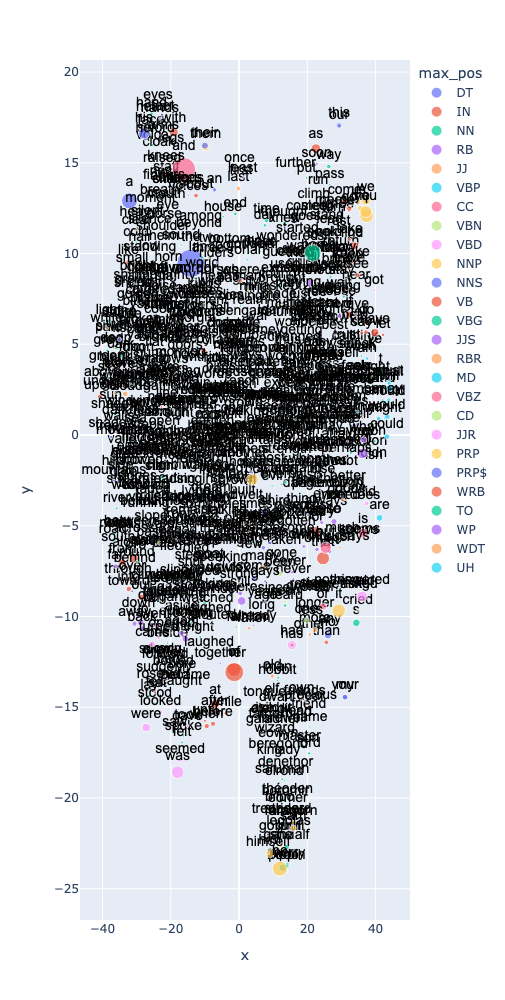

In [162]:
import plotly.express as px

# Example adjustment, assuming 'n' column exists and you want to use it for sizing:
px.scatter(X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos',  # Assuming 'max_pos' is what you meant by 'pos_max'
           hover_name='term_str',          
           size='n',  # Updated to use 'n' instead of 'tfidf_sum'
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

### DESCRIPTION: 

#### Character Focus: The presence of so many central characters at high y values underscores their importance in the narrative. Characters like Frodo, Gandalf, and Aragorn are essential to the driving force of the plot, each representing different facets of heroism and leadership.
#### Modal Verbs and Narrative Tone: The clustering of modal verbs at high x values may also indicate sections of the text where the narrative tone involves speculation, planning, or deliberation about future actions, which are critical elements in the unfolding of the saga’s epic journey.
#### Emotional and Thematic Depth: The variation in y values, especially with characters, can be interpreted as a measure of emotional and thematic depth, with higher values possibly correlating to pivotal chapters or scenes where these characters play significant roles.

### The analysis of the t-SNE plot with respect to the "Lord of the Rings" saga suggests a strong narrative focus on character development and the themes of destiny, duty, and moral choices. The clustering patterns and the position of terms significantly contribute to understanding how Tolkien weaves complex narrative strands and character arcs together, using language that frequently invokes notions of necessity and contemplation about the future, alongside a deep focus on character-driven storytelling. This approach not only helps in appreciating the linguistic texture of Tolkien's work but also in understanding the narrative mechanics that underpin the saga’s enduring appeal.

In [163]:
LIB_2 = pd.read_csv('LIB.csv')
LIB_2

book_id                  title                        part  \
0        1  The Lord of the Rings  The Fellowship of the Ring   
1        2  The Lord of the Rings  The Fellowship of the Ring   
2        3  The Lord of the Rings              The Two Towers   
3        4  The Lord of the Rings              The Two Towers   
4        5  The Lord of the Rings      The Return of the King   
5        6  The Lord of the Rings      The Return of the King   

             author  year_of_publish  
0  J. R. R. Tolkien  21 October 1954  
1  J. R. R. Tolkien  21 October 1954  
2  J. R. R. Tolkien    21 April 1955  
3  J. R. R. Tolkien    21 April 1955  
4  J. R. R. Tolkien   5 January 1956  
5  J. R. R. Tolkien   5 January 1956

## RIF 1

In [164]:
# Calculate average sentiment per chapter
EMO_CHAPS = BOW_SENT.groupby(['book_id', 'chap_num'])['sentiment'].mean().unstack(fill_value=0)

# Generate the linkage matrix for hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(EMO_CHAPS.T, 'ward')

# Plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=EMO_CHAPS.columns, leaf_rotation=90)
plt.title('Hierarchical Clustering of Sentiment by Chapter')
plt.xlabel('Chapter')
plt.ylabel('Distance')
plt.show()

## RIF 2

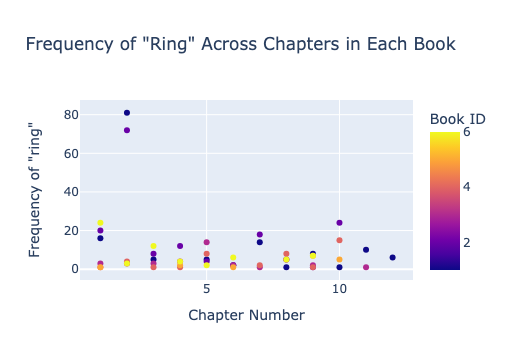

In [165]:
# Filter the BOW dataframe for the term 'ring' and plot its frequency
ring_counts = BOW[BOW.index.get_level_values('term_str') == 'ring'].reset_index()

# Create a scatter plot tracking 'ring' frequency across chapters
px.scatter(ring_counts, x='chap_num', y='n', color='book_id',
           labels={'n': 'Frequency of "ring"', 'chap_num': 'Chapter Number', 'book_id': 'Book ID'},
           title='Frequency of "Ring" Across Chapters in Each Book').show()

## RIF 3

In [167]:
characters = ['sauron', 'frodo', 'gandalf', 'gollum', 'aragorn']
character_counts = BOW[BOW.index.get_level_values('term_str').isin(characters)].reset_index()

# Pivot this data to have characters as columns
character_pivot = character_counts.pivot_table(index=['book_id', 'chap_num'], columns='term_str', values='n', fill_value=0)

print(character_pivot)

term_str          aragorn  frodo  gandalf  gollum  sauron
book_id chap_num                                         
1       1               0     58       41       2       0
        2               1     88       55      31       5
        3               0    104       29       0       0
        4               0     46        1       0       0
        5               0     52       11       0       0
...                   ...    ...      ...     ...     ...
6       5              26      4       15       0       2
        6              21     23       19       0       0
        7               0     11       25       0       0
        8               0     58        2       0       0
        9               0     52        4       0       0

[61 rows x 5 columns]


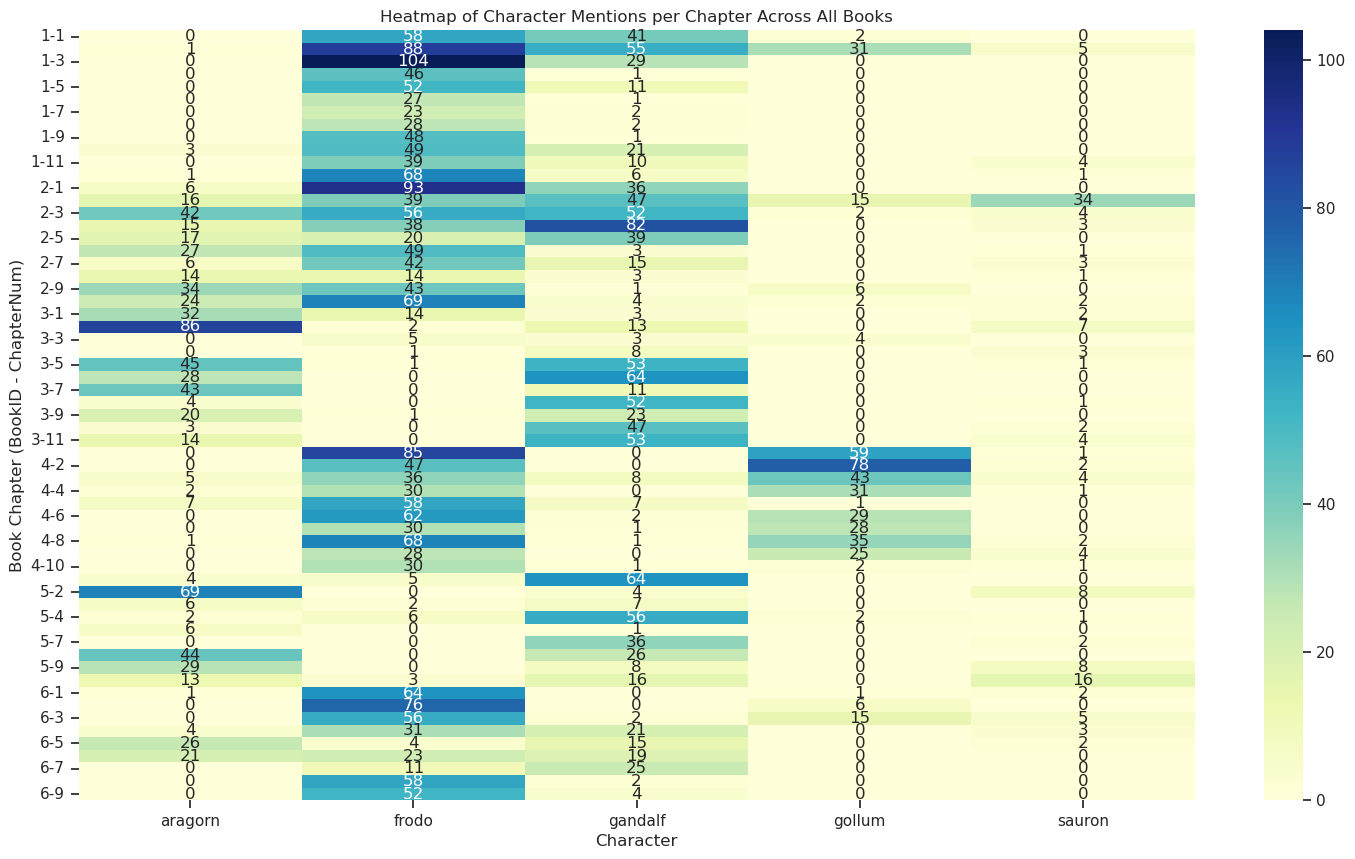

In [168]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume character_pivot_complete is already filled and indexed correctly
plt.figure(figsize=(18, 10))
sns.heatmap(character_pivot, cmap="YlGnBu", annot=True, fmt="d")
plt.title('Heatmap of Character Mentions per Chapter Across All Books')
plt.xlabel('Character')
plt.ylabel('Book Chapter (BookID - ChapterNum)')
plt.show()


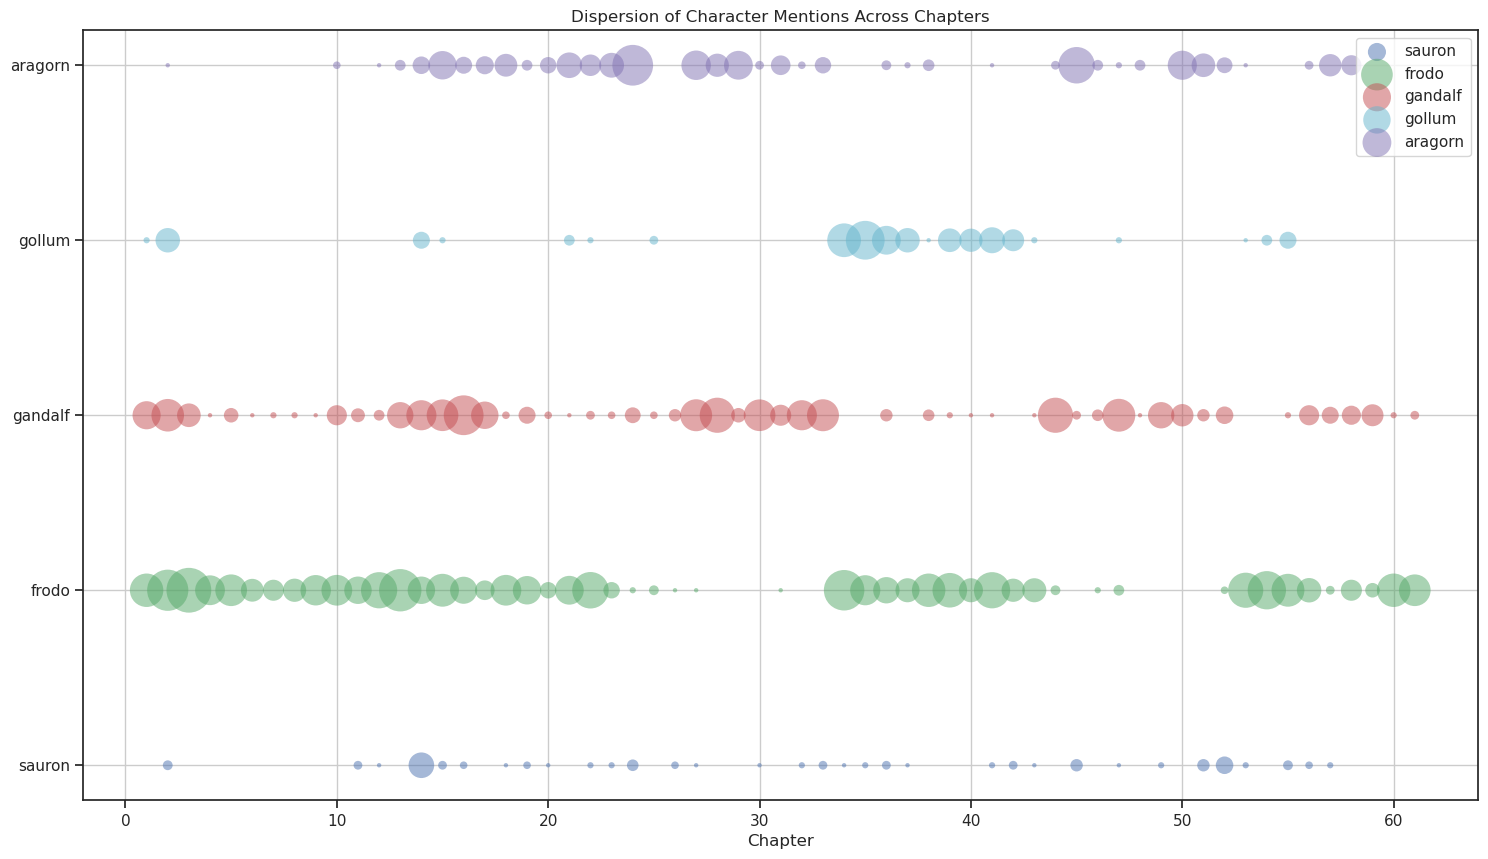

In [169]:
# Dispersion Plot
from matplotlib.collections import EventCollection

fig, ax = plt.subplots(figsize=(18, 10))
colors = ['b', 'g', 'r', 'c', 'm']
x_positions = np.arange(1, 62)  # Assuming 61 chapters linearly aligned

for idx, character in enumerate(characters):
    y_positions = character_pivot[character]
    ax.scatter(x_positions, [idx] * len(y_positions), c=colors[idx], label=character, alpha=0.5, edgecolors='none', s=y_positions*10)

ax.set_yticks(range(len(characters)))
ax.set_yticklabels(characters)
ax.set_xlabel('Chapter')
ax.set_title('Dispersion of Character Mentions Across Chapters')
plt.legend()
plt.grid(True)
plt.show()


## RIF 1

### Cluster 1 (Blue): Chapters 1, 3, and 2 are grouped together, with Chapter 1 ("A Long-expected Party") and Chapter 2 ("The Shadow of the Past") showing a close relationship. This suggests similar sentiment, likely due to the introduction of the Ring's dark history closely following the lighter, festive tones of Bilbo's birthday party. Chapter 3 ("Three is Company"), while still linked, shows a bit more distance, indicating a shift as the hobbits begin their journey, introducing elements of risk and adventure.
### Cluster 2 (Red): This cluster includes Chapters 8, 2, and 3. Chapter 8 ("Fog on the Barrow-Downs") is closely linked with Chapter 2, suggesting that the ominous and dark sentiments of learning about the Ring and the dangerous adventure in the Barrow-Downs resonate similarly in sentiment analysis.
### Cluster 3 (Green): Chapter 12 ("Flight to the Ford") stands alone initially and then links with Chapter 11 ("A Knife in the Dark"). These chapters, which cover the attack at Weathertop and the consequent flight to Rivendell, are filled with high tension and peril, highlighting a distinct shift to more intense, negative emotions compared to other chapters.
### Cluster 4 (Orange): Comprising Chapters 5 through 10, this large cluster suggests a general similarity in sentiment across several chapters that deal with the hobbits' early adventures from "A Conspiracy Unmasked" to "Strider." These chapters, while varied in events, might share a mix of curiosity, mild danger, and camaraderie that doesn't swing to the extremes of joy or despair.

## RIF 2

### The Fellowship of the Ring
#### Book I 
##### Chapter 2: The Shadow of the Past - The term "ring" appears 81 times, the highest in any chapter of Book I. This is where Gandalf explains the history of the One Ring to Frodo, making it a central focus. The term appears moderately throughout other chapters, with notable mentions in Chapter 1 during Bilbo's birthday party and in Chapter 11, where the peril around the ring escalates as the hobbits face the Nazgul. Lower frequencies in chapters like Chapter 8 and Chapter 10 suggest a focus on immediate dangers and character development over the broader quest.
#### Book II
##### Chapter 2: The Council of Elrond - Another peak occurs with 72 mentions, as the council discusses the fate of the Ring, reflecting its central role in the plot. High frequency in Chapter 10, "The Breaking of the Fellowship," highlights the climax of the book where the fellowship is tested, and the ring's influence is profound.
### The Two Towers
#### Book III
##### Moderate to low occurrences across Book III, with slightly higher counts in chapters like Chapter 1, reflecting on Boromir's fall due to the Ring, and Chapter 10, where Saruman's ambition for the Ring is explored. Chapter 2: The Riders of Rohan and Chapter 10: The Voice of Saruman show notable mentions, tying into the ring's wider political and social impact.
#### Book IV
##### Generally lower frequencies, focusing more on character journeys like Frodo's and Sam's, away from the central political narratives. However, significant mentions in Chapter 9 ("Shelob's Lair") and Chapter 10 ("The Choices of Master Samwise") emphasize critical moments of temptation and decision around the Ring.
### The Return of the King
#### Book V
##### As the narrative moves towards climax in Book V, mentions of the ring are crucial in chapters like Chapter 10, "The Black Gate Opens," symbolizing the final confrontations influenced by the Ring.
#### Book VI
##### Peaks in Chapter 3: Mount Doom, where the ring's destiny is fulfilled, with 24 mentions. This is a pivotal chapter where the ring is destroyed, marking the resolution of the central conflict.


### The distribution of the term "ring" aligns closely with narrative peaks, character developments, and crucial plot pivots. Higher frequencies coincide with chapters discussing the ring's lore, its impact on bearers, and key plot resolutions. The scattering of the term's frequency across the books and chapters not only highlights its central thematic significance but also mirrors the physical and emotional journey of the characters involved with the Ring.

## RIF 3

### Character Mentions and Story Development: 
#### Frodo and Gandalf: These characters are central figures, as indicated by their consistent mentions throughout the series. Their involvement is crucial, acting as the narrative's backbone.
#### Gollum and Sauron: These characters exhibit peaks in mentions at critical times in the storyline. Gollum's mentions increase as the story approaches key moments of conflict and decision, particularly around the Ring, reflecting his growing influence and complexity. Similarly, Sauron's mentions peak as his threat becomes imminent, reinforcing his role as the overarching antagonist.

### Dispersion of Character Mentions: 
#### Frodo: The steady mention of Frodo across all parts of the series underscores his role as the protagonist. His journey, challenges, and evolution are a continuous thread that drives the narrative forward.
#### Aragorn: Spikes in mentions of Aragorn during significant events, such as battles or moments of leadership, highlight his role as a key figure in the resistance against Sauron. These mentions align with pivotal narrative shifts where his leadership is most needed.

#### The heatmap and dispersion plots collectively illustrate how Tolkien strategically uses character mentions to emphasize moments of narrative significance and character development. The visualization of these mentions in plots can help depict the dynamic shifts in narrative focus, aligning closely with the plot's progression and the evolving roles of the characters. This pattern not only enriches our understanding of the narrative structure but also highlights the intricate weaving of characters into the fabric of the story, each playing a role that resonates with their thematic significance and the story’s climactic needs.

# INTERPRETATION

#### I found it interesting that TF-IDF highlights the significance of specific terms like "Mordor," "Gondor," and "Hobbit" across the trilogy, pinpointing where Tolkien accentuates key themes or plot shifts. This method reveals how Tolkien stages the narrative, emphasizing the growing menace of Mordor as the fellowship approaches, thus tracking the rising tension and conflict. Word2Vec extends this by exploring semantic relationships, such as linking "Sauron" with "evil," or "Aragorn" with "king," showing how Tolkien connects different narrative elements through language. The association of "ring" with "burden" through Word2Vec underscores the profound theme of power and corruption, central to the plot. Sentiment analysis across the chapters provides insight into the emotional pacing of the story, corresponding with major plot developments and character arcs. The heatmap of character mentions quantitatively reflects the narrative focus, notably on characters like Aragorn during pivotal moments, aligning with his role as a leader. Similarly, the frequent mentions of Frodo and Sam highlight their central role and the emotional rollercoaster they endure, marked by significant highs and lows in sentiment as they approach Mordor. Tolkien’s profound philological expertise is evident in the sophisticated language and deep mythological constructs within Middle-earth. The layered narrative analysis through these advanced tools shows how Tolkien uses language not just to tell a story but to enrich the reader’s immersion into the world he created. Words like "precious" reflect the dual obsession of Gollum (who was mentioned significantly through the 2nd part) and the corruptive nature of the Ring, adding layers of meaning and emotional resonance to the narrative. It demonstrates Tolkien's ability to weave complex narratives that combine character development, thematic exploration, and linguistic precision. These insights not only deepen our appreciation of his work but also showcase the potential of analytical tools to uncover new perspectives in literary studies.